BTC Price Data Analysis (Percentage Change)

This script performs a basic analysis of BTC/USDT hourly price data, focusing on the behavior of the percentage change in the close price.

## 1. Load Data and Libraries

In [188]:
import sys
import os
current_dir = os.getcwd()
# Navigate up one level to the project root (e.g., /path/to/my_project)
project_root = os.path.abspath(os.path.join(current_dir, '../src'))
# Add the project root to sys.path so Python can find 'src' as a top-level package
if project_root not in sys.path:
    sys.path.append(project_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

from src.data_analysis.bar_aggregation import create_volume_bars, create_dollar_bars, create_price_change_bars, create_tick_imbalance_bars
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox

# Set plot style
sns.set(style="whitegrid")

print("Libraries loaded.")

Libraries loaded.


### Helper Functions

In [149]:
def sma(series, n):
    """Calculates the Simple Moving Average."""
    return series.rolling(window=n).mean()

def awesome_oscillator(high: pd.Series, low: pd.Series, fast_period: int = 5, slow_period: int = 34) -> pd.Series:
    """Calculates the Awesome Oscillator."""
    median_price = (high + low) / 2
    ao = sma(median_price, fast_period) - sma(median_price, slow_period)
    return ao

## 2. Load and Prepare Data

In [150]:
DATA_PATH = '/home/leocenturion/Documents/postgrados/ia/tp-final/Tp Final/data/binance/python/data/spot/daily/klines/BTCUSDT/1h/BTCUSDT_consolidated_klines.csv'
df = pd.read_csv(DATA_PATH)

# Convert to datetime and set as index
df['timestamp'] = pd.to_datetime(df['date'])
df.set_index('timestamp', inplace=True)
df.sort_index(inplace=True)
# The original 'date' column is now redundant. Drop it to prevent conflicts.
df.drop(columns=['date'], inplace=True)

print("Data loaded and prepared. Shape:", df.shape)
print(df.head())

Data loaded and prepared. Shape: (51280, 12)
                              unix     open     high      low    close  \
timestamp                                                                
2020-01-01 00:00:00  1577836800000  7195.24  7196.25  7175.46  7177.02   
2020-01-01 01:00:00  1577840400000  7176.47  7230.00  7175.71  7216.27   
2020-01-01 02:00:00  1577844000000  7215.52  7244.87  7211.41  7242.85   
2020-01-01 03:00:00  1577847600000  7242.66  7245.00  7220.00  7225.01   
2020-01-01 04:00:00  1577851200000  7225.00  7230.00  7215.03  7217.27   

                     Volume BTC     close_time   Volume USDT  tradeCount  \
timestamp                                                                  
2020-01-01 00:00:00  511.814901  1577840399999  3.675857e+06        7640   
2020-01-01 01:00:00  883.052603  1577843999999  6.365953e+06        9033   
2020-01-01 02:00:00  655.156809  1577847599999  4.736719e+06        7466   
2020-01-01 03:00:00  783.724867  1577851199999  5.667367

## 3. Analyze Close Price Percentage Change

We calculate the percentage change of the closing price. This normalizes the price changes and is a standard way to analyze financial time series. It's also a crucial step for time series modeling, as models like ARIMA often require stationary data.

In [7]:
# Calculate the percentage change in the closing price
df['close_pct_change'] = (df['close'].pct_change()) * 100

# Drop the first row with a NaN value resulting from the pct_change operation
df.dropna(subset=['close_pct_change'], inplace=True)

print("Close price percentage change calculated.")
print(df[['close', 'close_pct_change']].head())

Close price percentage change calculated.
               close  close_pct_change
count   51277.000000      51277.000000
mean    46061.568015          0.007458
std     31005.486224          0.673440
min      4130.640000        -18.211473
25%     21463.410000         -0.231775
50%     38802.630000          0.006666
75%     63003.920000          0.252631
max    126011.180000         17.383989


### 3.1. Time Series Plot of Price Percentage Change

Plotting the close price percentage change over time...


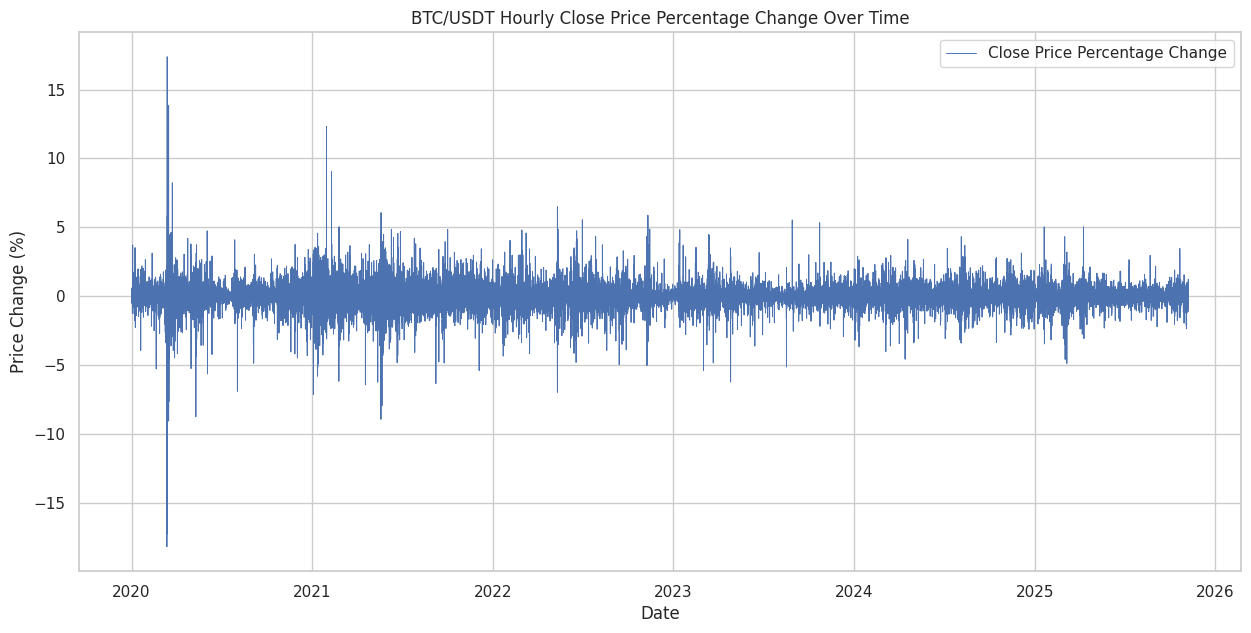

In [5]:
print("Plotting the close price percentage change over time...")
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['close_pct_change'], label='Close Price Percentage Change', linewidth=0.7)
plt.title('BTC/USDT Hourly Close Price Percentage Change Over Time')
plt.xlabel('Date')
plt.ylabel('Price Change (%)')
plt.legend()
plt.show()

The plot shows that the percentage change is centered around zero but exhibits volatility clustering—periods of high volatility are followed by more high volatility, and vice versa.

### 3.2. Distribution of Price Percentage Change

Plotting the distribution of the close price percentage change...


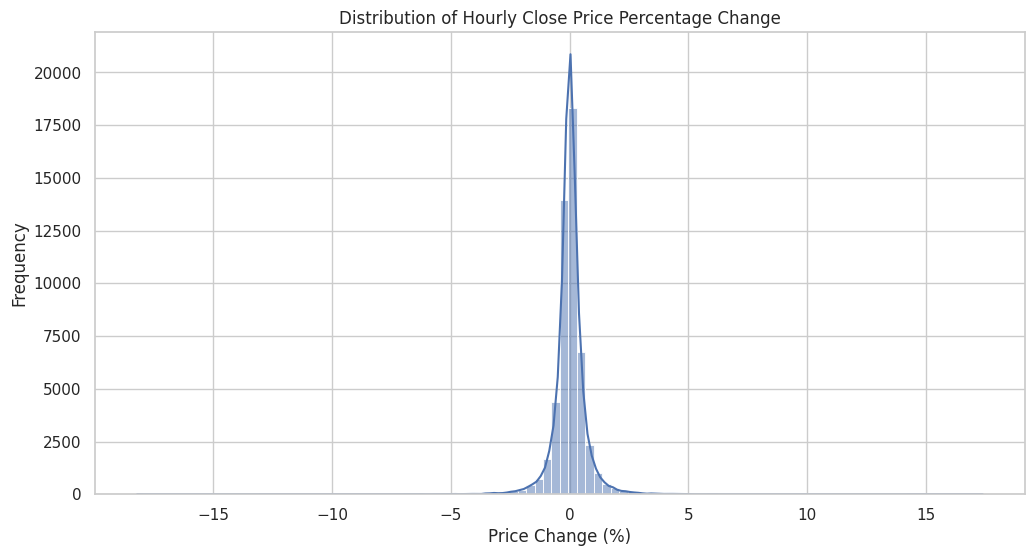

In [51]:
print("Plotting the distribution of the close price percentage change...")
plt.figure(figsize=(12, 6))
sns.histplot(df['close_pct_change'], bins=100, kde=True)
plt.title('Distribution of Hourly Close Price Percentage Change')
plt.xlabel('Price Change (%)')
plt.ylabel('Frequency')
plt.show()

The distribution is highly leptokurtic (sharply peaked at zero with heavy tails), which is a classic characteristic of financial returns. This indicates that extreme price changes occur more frequently than a normal distribution would predict.

### 3.3. Descriptive Statistics

In [8]:
print("Descriptive Statistics for Close Price Percentage Change:")
print(df['close_pct_change'].describe())

Descriptive Statistics for Close Price Percentage Change:
count    88779.000000
mean         0.011197
std          0.990297
min        -58.028204
25%         -0.242369
50%          0.000000
75%          0.269917
max        132.323232
Name: close_pct_change, dtype: float64


The mean is very close to zero. The standard deviation confirms the significant volatility, and the min/max values highlight the extreme hourly percentage swings present in the data.

### 3.4. Stationarity Test (Augmented Dickey-Fuller)

We perform an ADF test to formally check if the percentage change series is stationary. The null hypothesis is that the series is non-stationary.

In [9]:
print("Performing Augmented Dickey-Fuller (ADF) test for stationarity...")
adf_result = adfuller(df['close_pct_change'])

print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'\t{key}: {value:.3f}')

if adf_result[1] <= 0.05:
    print("\nResult: The series is stationary (p-value <= 0.05).")
else:
    print("\nResult: The series is not stationary (p-value > 0.05).")

Performing Augmented Dickey-Fuller (ADF) test for stationarity...
ADF Statistic: -36.1781
p-value: 0.0000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567

Result: The series is stationary (p-value <= 0.05).


The extremely low p-value allows us to confidently reject the null hypothesis, confirming that the percentage change series is stationary. This is a suitable input for time series models.

### 3.5. Zoomed-in Histogram of Price Percentage Change

Plotting the zoomed-in distribution for price changes between -0.1% and 0.1%...


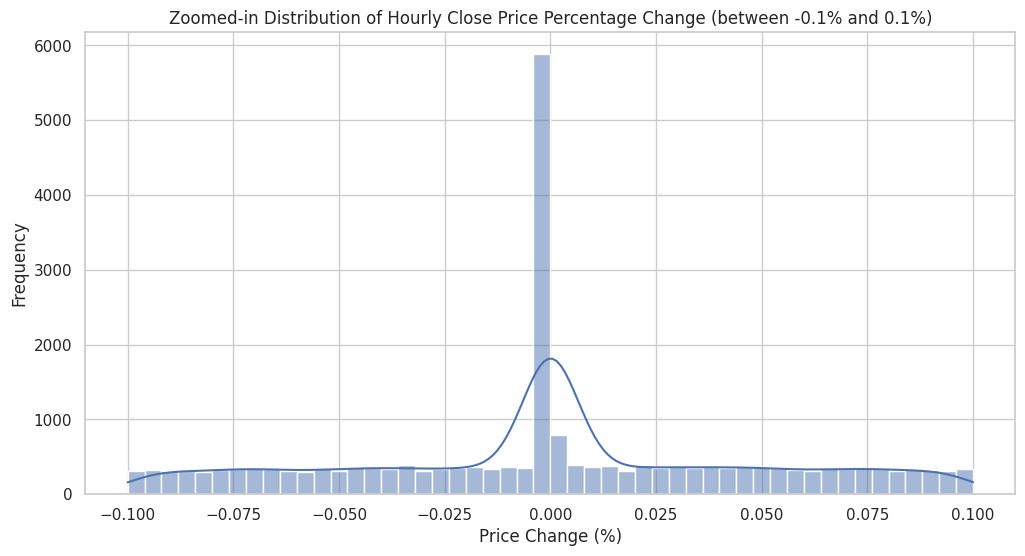

In [10]:
print("Plotting the zoomed-in distribution for price changes between -0.1% and 0.1%...")
zoomed_data = df['close_pct_change'].loc[(df['close_pct_change'] >= -0.1) & (df['close_pct_change'] <= 0.1)]

plt.figure(figsize=(12, 6))
sns.histplot(zoomed_data, bins=50, kde=True)
plt.title('Zoomed-in Distribution of Hourly Close Price Percentage Change (between -0.1% and 0.1%)')
plt.xlabel('Price Change (%)')
plt.ylabel('Frequency')
plt.show()

Zooming in on the vast majority of the data, we can see the distribution around zero more clearly.

### 3.6. Cumulative Distribution of Absolute Price Change

Plotting the Cumulative Distribution Function (CDF) of absolute percentage changes...


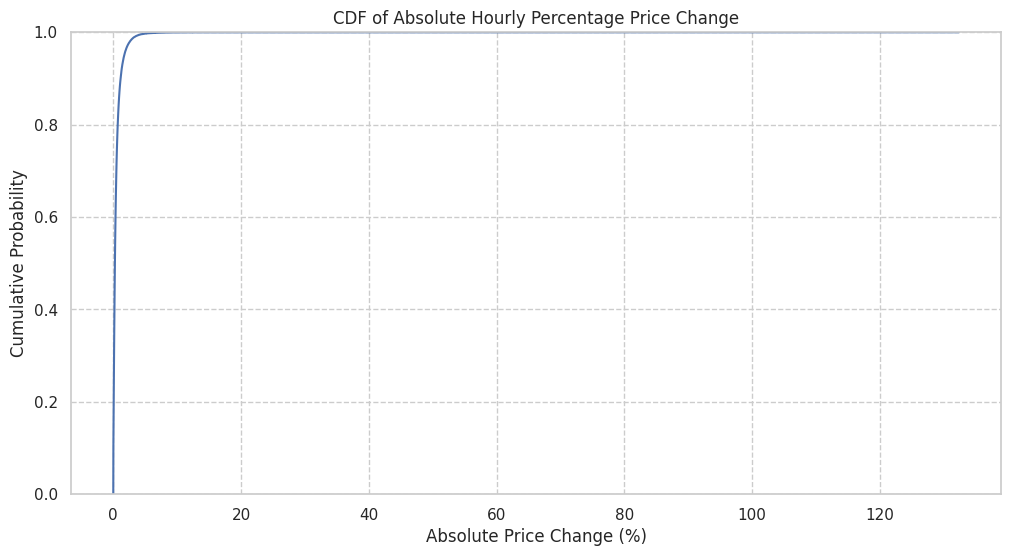

In [11]:
print("Plotting the Cumulative Distribution Function (CDF) of absolute percentage changes...")
df['abs_close_pct_change'] = df['close_pct_change'].abs()

plt.figure(figsize=(12, 6))
sns.ecdfplot(df['abs_close_pct_change'])
plt.title('CDF of Absolute Hourly Percentage Price Change')
plt.xlabel('Absolute Price Change (%)')
plt.ylabel('Cumulative Probability')
plt.grid(True, which="both", ls="--")
plt.show()

The CDF plot shows the probability of observing a price change of a certain magnitude or less. For example, you can use it to find the value on the x-axis that corresponds to 0.95 on the y-axis to see what magnitude of price change accounts for 95% of all hourly movements.

## 4. Awesome Oscillator Analysis

We will now analyze the Awesome Oscillator (AO). We'll compute it in two ways:
1. Using the raw `High` and `Low` prices.
2. Using the percentage change of the `High` and `Low` prices.

This comparison will help visualize how the oscillator behaves on the price series versus the returns series.

In [12]:
# Calculate AO on raw prices
print("Calculating Awesome Oscillator on raw prices...")
df['ao_price'] = awesome_oscillator(df['high'], df['low'])

# Calculate AO on percentage change
print("Calculating Awesome Oscillator on price percentage changes...")
df['high_pct_change'] = df['high'].pct_change()
df['low_pct_change'] = df['low'].pct_change()

# Fill NaNs created by pct_change for AO calculation
high_pct_change_filled = df['high_pct_change'].fillna(0)
low_pct_change_filled = df['low_pct_change'].fillna(0)
df['ao_pct_change'] = awesome_oscillator(high_pct_change_filled, low_pct_change_filled)

print("Awesome Oscillators calculated.")
print(df[['ao_price', 'ao_pct_change']].head())

Calculating Awesome Oscillator on raw prices...
Calculating Awesome Oscillator on price percentage changes...
Awesome Oscillators calculated.
                     ao_price  ao_pct_change
timestamp                                   
2015-02-19 20:00:00       NaN            NaN
2015-02-19 21:00:00       NaN            NaN
2015-02-19 22:00:00       NaN            NaN
2015-02-19 23:00:00       NaN            NaN
2015-02-20 00:00:00       NaN            NaN


### 4.1. Plotting Awesome Oscillators

Plotting Awesome Oscillators for comparison...


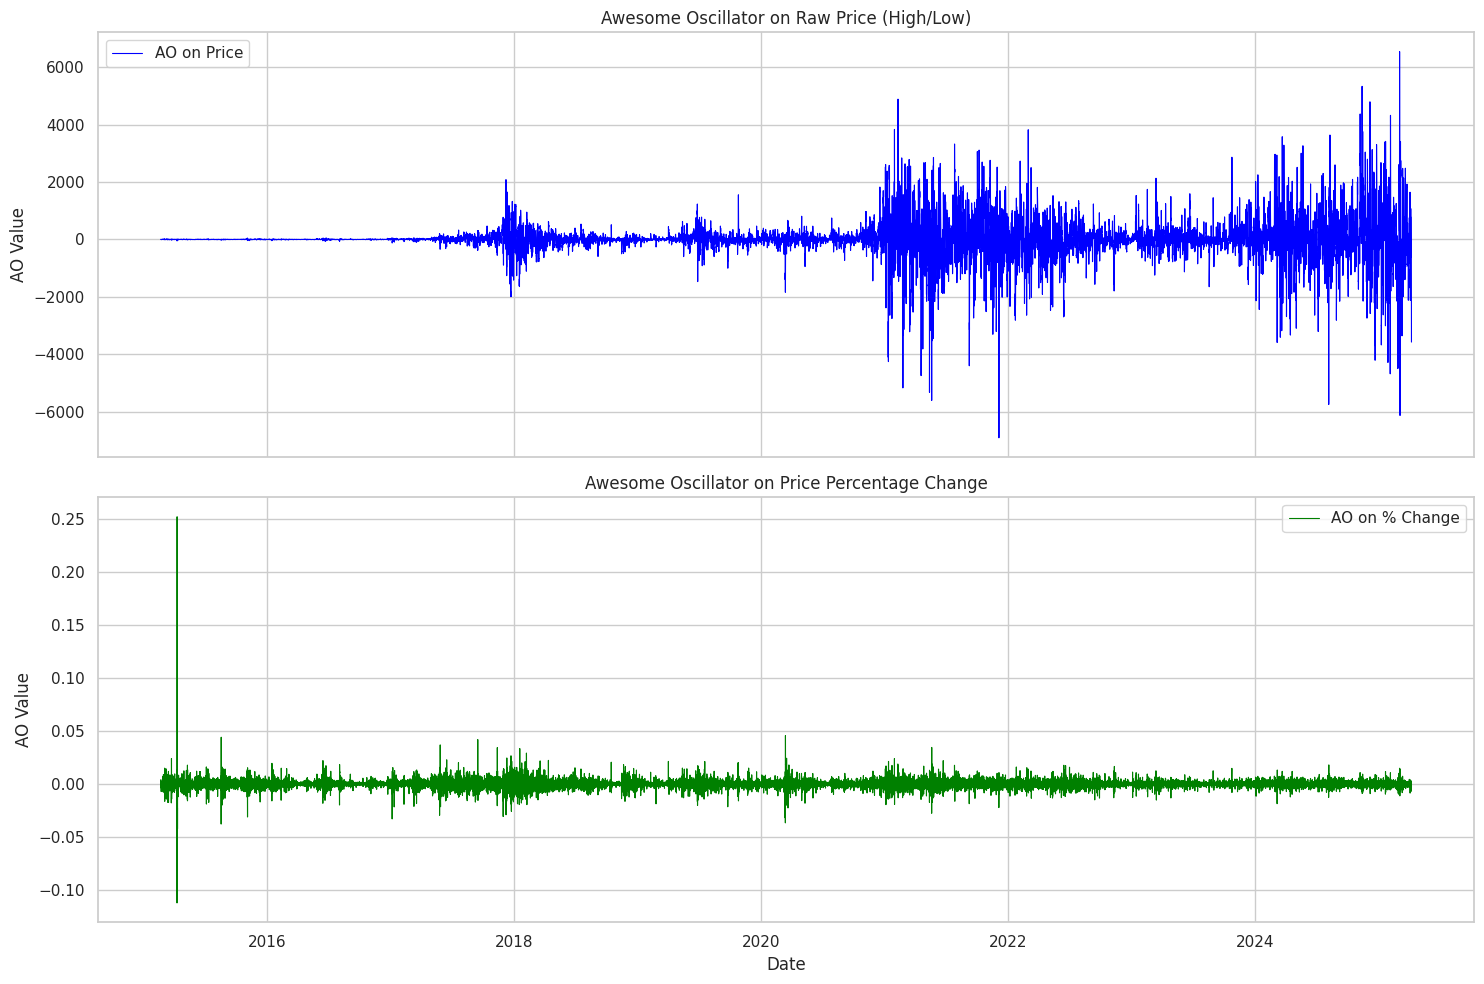

In [13]:
print("Plotting Awesome Oscillators for comparison...")
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Plot AO on price
axes[0].plot(df.index, df['ao_price'], label='AO on Price', color='blue', linewidth=0.8)
axes[0].set_title('Awesome Oscillator on Raw Price (High/Low)')
axes[0].set_ylabel('AO Value')
axes[0].grid(True)
axes[0].legend()

# Plot AO on percentage change
axes[1].plot(df.index, df['ao_pct_change'], label='AO on % Change', color='green', linewidth=0.8)
axes[1].set_title('Awesome Oscillator on Price Percentage Change')
axes[1].set_ylabel('AO Value')
axes[1].grid(True)
axes[1].legend()

plt.xlabel('Date')
fig.tight_layout()
plt.show()

The plots show a stark difference. The AO on raw prices reflects longer-term price trends and momentum, with large swings. The AO on percentage change is much more stationary and centered around zero, reflecting the short-term volatility and returns behavior rather than the price level itself.

## 5. Consecutive Runs Analysis

Here, we analyze the length of consecutive periods of positive or negative price changes. A "run" is a sequence of one or more hours where the price change has the same sign. For example:
- A single hour of gains is a run of `+1`.
- Three consecutive hours of gains is a run of `+3`.
- Two consecutive hours of losses is a run of `-2`.

This analysis can help identify if there is momentum or mean-reversion behavior in the short term.

In [14]:
print("Analyzing consecutive runs of positive and negative price changes...")

# Determine the sign of the price change, treating 0 as neutral
signs = np.sign(df['close_pct_change'])
# We replace 0s with the previous sign to not break a run
signs = signs.replace(0, np.nan).ffill().fillna(0)

# Identify blocks of consecutive signs
blocks = signs.diff().ne(0).cumsum()

# Calculate the length of each run and multiply by its sign
runs = signs.groupby(blocks).apply(lambda x: x.size * x.iloc[0] if x.iloc[0] != 0 else 0)

# Filter out any zero-runs that might have occurred at the beginning
runs = runs[runs != 0]

print("Consecutive runs calculated. Descriptive statistics:")
print(runs.describe())

Analyzing consecutive runs of positive and negative price changes...
Consecutive runs calculated. Descriptive statistics:
count    45632.000000
mean         0.052003
std          2.587521
min        -45.000000
25%         -1.000000
50%          0.000000
75%          1.000000
max         69.000000
Name: close_pct_change, dtype: float64



Plotting the histogram of consecutive runs...


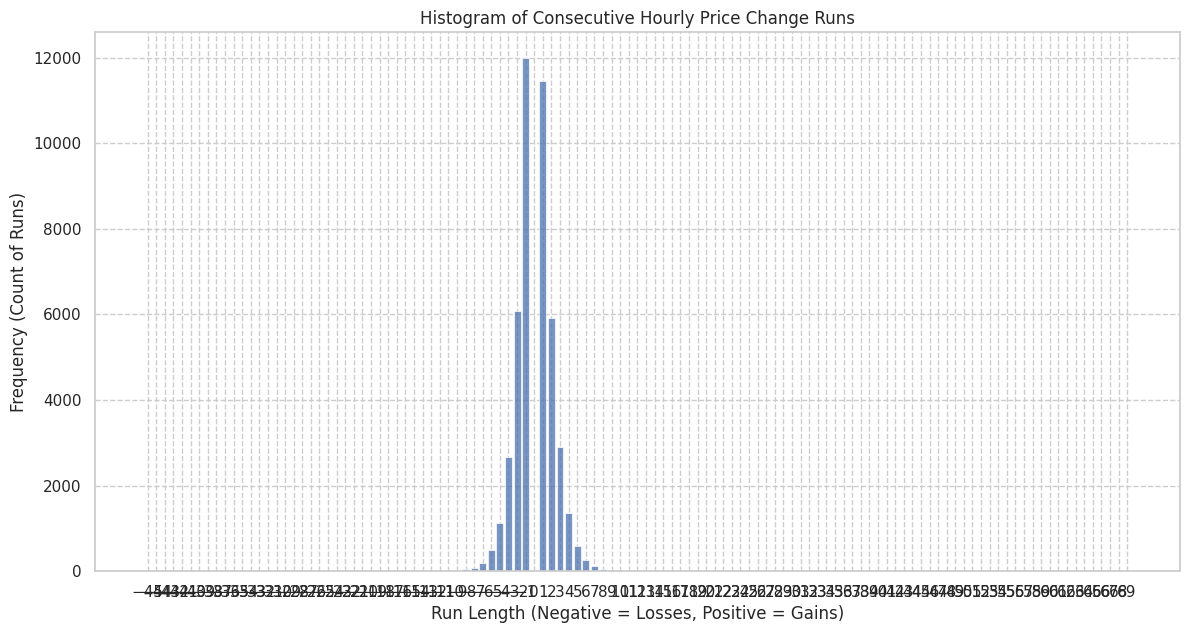

In [15]:
# Plot a histogram of the runs
print("\nPlotting the histogram of consecutive runs...")
plt.figure(figsize=(14, 7))
sns.histplot(runs, discrete=True, stat="count", shrink=0.8)
plt.title('Histogram of Consecutive Hourly Price Change Runs')
plt.xlabel('Run Length (Negative = Losses, Positive = Gains)')
plt.ylabel('Frequency (Count of Runs)')
plt.xticks(np.arange(int(runs.min()), int(runs.max()) + 1, 1))
plt.grid(True, which="both", ls="--")
plt.show()

The histogram shows that short runs (of length 1, 2, or 3) are very common, while long streaks of consecutive gains or losses are increasingly rare. This is consistent with the behavior of a volatile asset where the direction can change frequently.

### 5.1. Run Transition Probability Analysis

Now, we'll analyze the probability of transitioning from a run of one length to another. For example, what is the likelihood that a 1-hour run of gains is followed by a 1-hour run of losses? This can be modeled as a Markov chain, and we can compute the transition matrix.

We will focus on transitions between runs of length -5 to +5.

In [16]:
print("Calculating run transition probabilities...")
# Create a DataFrame of consecutive run pairs
transitions = pd.DataFrame({'from': runs, 'to': runs.shift(-1)}).dropna()
transitions = transitions.astype(int)

# Create a transition count matrix using crosstab
transition_counts = pd.crosstab(transitions['from'], transitions['to'])

# Calculate transition probabilities by dividing each row by its sum
transition_probabilities = transition_counts.div(transition_counts.sum(axis=1), axis=0)

# Filter and reindex to focus on the -5 to +5 range, filling missing transitions with 0
run_range = range(-5, 6)
# Remove 0 from the range as it's not a valid run length in our data
run_range = [i for i in run_range if i != 0]

transition_matrix = transition_probabilities.reindex(index=run_range, columns=run_range, fill_value=0)

print("Transition Matrix (-5 to +5):")
print(transition_matrix.to_string(float_format="%.3f"))

Calculating run transition probabilities...
Transition Matrix (-5 to +5):
to      -5    -4    -3    -2    -1     1     2     3     4     5
from                                                            
-5   0.000 0.000 0.000 0.000 0.000 0.505 0.255 0.122 0.050 0.024
-4   0.000 0.000 0.000 0.000 0.000 0.493 0.265 0.119 0.059 0.022
-3   0.000 0.000 0.000 0.000 0.000 0.509 0.255 0.123 0.058 0.029
-2   0.000 0.000 0.000 0.000 0.000 0.489 0.263 0.136 0.064 0.024
-1   0.000 0.000 0.000 0.000 0.000 0.513 0.260 0.124 0.058 0.026
 1   0.020 0.047 0.119 0.267 0.534 0.000 0.000 0.000 0.000 0.000
 2   0.025 0.051 0.112 0.265 0.526 0.000 0.000 0.000 0.000 0.000
 3   0.020 0.052 0.114 0.280 0.515 0.000 0.000 0.000 0.000 0.000
 4   0.021 0.059 0.122 0.254 0.521 0.000 0.000 0.000 0.000 0.000
 5   0.030 0.047 0.111 0.276 0.501 0.000 0.000 0.000 0.000 0.000



Plotting the transition probability heatmap...


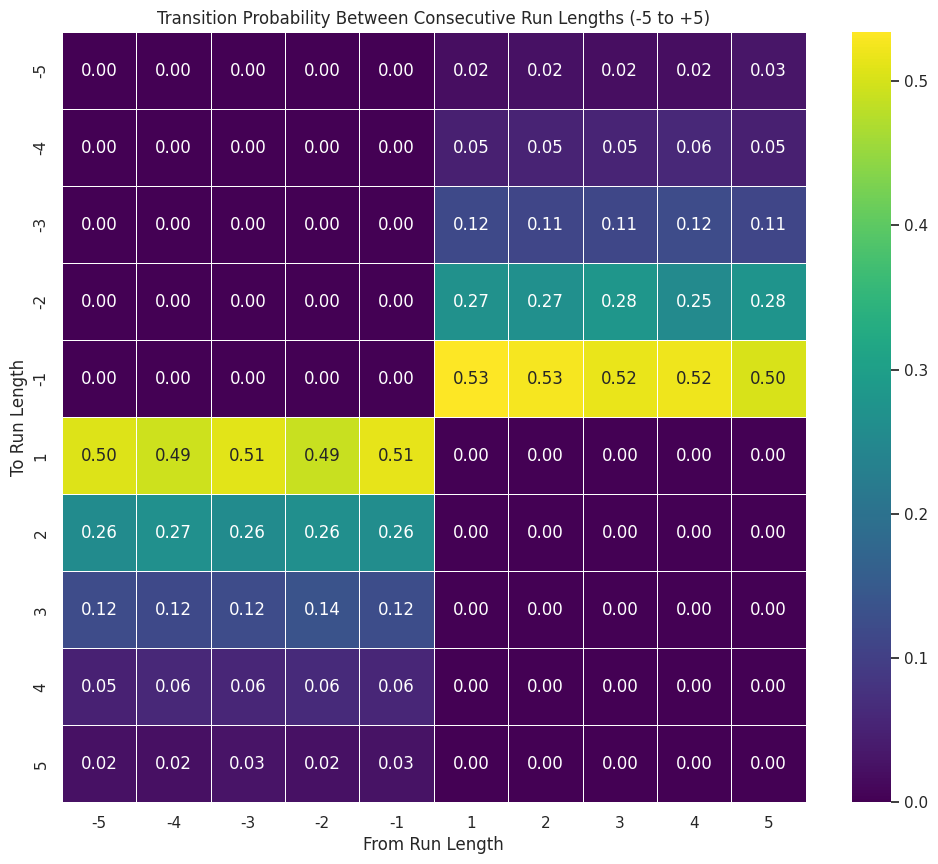

In [17]:
# Plot the transition matrix as a heatmap
print("\nPlotting the transition probability heatmap...")
plt.figure(figsize=(12, 10))
sns.heatmap(transition_matrix.T, annot=True, cmap='viridis', fmt='.2f', linewidths=.5)
plt.title('Transition Probability Between Consecutive Run Lengths (-5 to +5)')
plt.xlabel('From Run Length')
plt.ylabel('To Run Length')
plt.show()

The heatmap shows the probability of moving from a run length on the x-axis to a run length on the y-axis.

A key observation is the high probability along the anti-diagonal, especially for short runs. For example, there's a high likelihood that a run of `+1` is followed by a run of `-1`, and vice-versa. This suggests a strong tendency for the price direction to revert after short periods, which aligns with the previous observation that long runs are rare.

### 5.2. Conditional Probability of Run Continuation

Here we analyze the probability that a run of a certain length will continue for at least one more period. For example, given that we have observed two consecutive hours of price increases (a run of +2), what is the probability that the next hour will also be an increase, extending the run to +3?

This is calculated for positive and negative runs separately. The probability is:
`P(Run extends to N+1 | Run has reached length N) = (Total number of runs with length >= N+1) / (Total number of runs with length >= N)`

In [18]:
print("Calculating conditional probabilities of run continuation...")

positive_runs = runs[runs > 0]
negative_runs = runs[runs < 0]

continuation_probs = {
    'Positive': [],
    'Negative': []
}
run_lengths_to_check = range(1, 6)

for n in run_lengths_to_check:
    # Positive runs
    runs_ge_n = (positive_runs >= n).sum()
    runs_ge_n_plus_1 = (positive_runs >= n + 1).sum()
    prob_pos = runs_ge_n_plus_1 / runs_ge_n if runs_ge_n > 0 else 0
    continuation_probs['Positive'].append(prob_pos)

    # Negative runs
    runs_le_n = (negative_runs <= -n).sum()
    runs_le_n_plus_1 = (negative_runs <= -(n + 1)).sum()
    prob_neg = runs_le_n_plus_1 / runs_le_n if runs_le_n > 0 else 0
    continuation_probs['Negative'].append(prob_neg)

prob_df = pd.DataFrame(continuation_probs, index=[f'{i} -> {i+1}' for i in run_lengths_to_check])
prob_df.index.name = 'Run Extension'

print("Conditional Probabilities of Run Continuation:")
print(prob_df.to_string(float_format="%.3f"))

Calculating conditional probabilities of run continuation...
Conditional Probabilities of Run Continuation:
               Positive  Negative
Run Extension                    
1 -> 2            0.498     0.474
2 -> 3            0.479     0.439
3 -> 4            0.468     0.440
4 -> 5            0.465     0.455
5 -> 6            0.498     0.472



Plotting the run continuation probabilities...


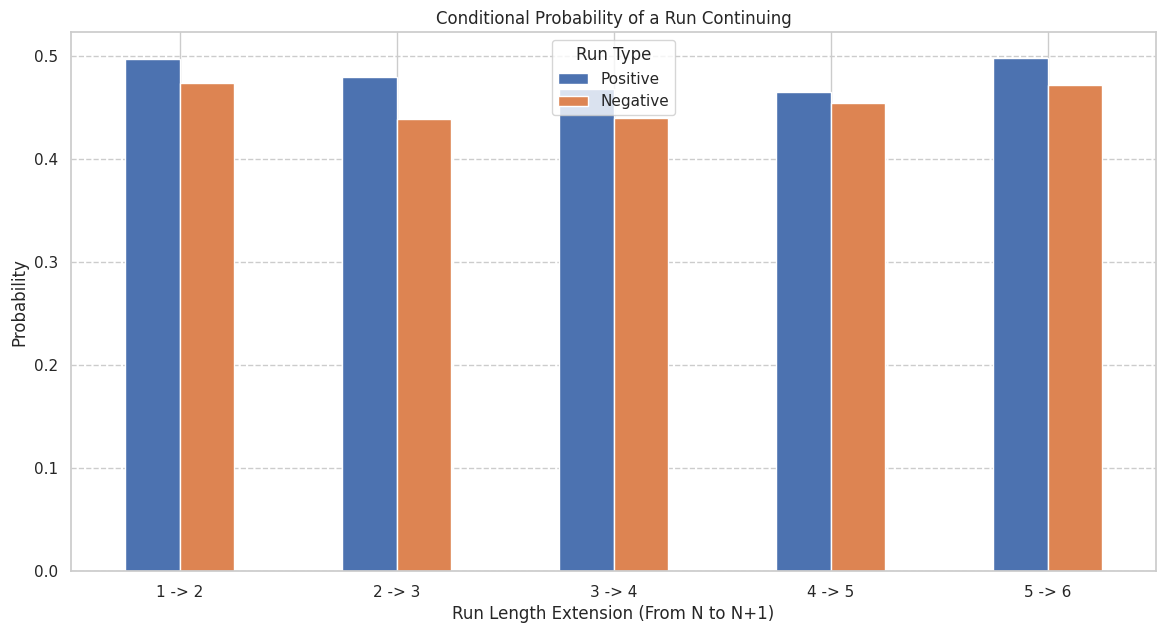

In [19]:
# Plot the continuation probabilities
print("\nPlotting the run continuation probabilities...")
prob_df.plot(kind='bar', figsize=(14, 7), rot=0)
plt.title('Conditional Probability of a Run Continuing')
plt.xlabel('Run Length Extension (From N to N+1)')
plt.ylabel('Probability')
plt.grid(axis='y', linestyle='--')
plt.legend(title='Run Type')
plt.show()

The bar chart shows the probability that a run of length N will extend to N+1. For both positive and negative runs, the probability of continuation is consistently below 0.5 and generally decreases as the run gets longer. This reinforces the idea of mean reversion in the hourly price changes; the longer a directional streak continues, the more likely it is to break.

## 6. Buy and Hold Performance Metrics

This section calculates standard performance metrics for a simple "buy and hold" strategy over the entire dataset. This provides a baseline against which any active trading strategy can be compared.

In [20]:
print("Calculating Buy and Hold performance metrics...")

# --- 1. Calculate Daily Returns ---
# Resample hourly data to daily data to get daily returns
daily_close = df['close'].resample('D').last()
daily_returns = daily_close.pct_change().dropna()

# --- 2. Define Parameters ---
risk_free_rate = 0.0
annualization_factor = 365 # Using 365 for crypto markets

# --- 3. Calculate Metrics ---
# Total Return
total_return = (df['close'].iloc[-1] / df['close'].iloc[0]) - 1

# Annualized Volatility
annualized_volatility = daily_returns.std() * np.sqrt(annualization_factor)

# Sharpe Ratio
if annualized_volatility > 0:
    sharpe_ratio = (daily_returns.mean() * annualization_factor - risk_free_rate) / annualized_volatility
else:
    sharpe_ratio = 0

# Max Drawdown
cumulative_returns = (1 + daily_returns).cumprod()
peak = cumulative_returns.expanding(min_periods=1).max()
drawdown = (cumulative_returns / peak) - 1
max_drawdown = drawdown.min()

# --- 4. Print Results ---
print("\n--- Buy and Hold Performance Summary ---")
print(f"Total Return: {total_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")

Calculating Buy and Hold performance metrics...

--- Buy and Hold Performance Summary ---
Total Return: 31995.25%
Annualized Volatility: 70.72%
Sharpe Ratio: 1.16
Maximum Drawdown: -83.27%


## 7. Volume and Dollar Bar Analysis

Time-based bars (like the hourly data we've used) are standard, but they don't account for market activity. During quiet periods, time bars have low volume and volatility, while during active periods, they can contain multiple significant market events.

An alternative is to use data-driven bars, such as **Volume Bars** and **Dollar Bars**.
- **Volume Bars**: A new bar is formed whenever a pre-defined amount of the asset (e.g., BTC) has been traded.
- **Dollar Bars**: A new bar is formed whenever a pre-defined value (e.g., in USDT) has been traded.

This approach samples data more frequently during high-activity periods and less frequently during low-activity periods, potentially providing a better signal for analysis and strategy development. We will use the average hourly volume and dollar value as thresholds to create these bars.

In [120]:
print("Creating Volume and Dollar bars...")

# Calculate thresholds based on the average hourly activity
avg_hourly_btc_volume = df['Volume BTC'].mean()
avg_hourly_usdt_volume = df['Volume USDT'].mean()

print(f"Using Volume Threshold: {avg_hourly_btc_volume:.2f} BTC")
print(f"Using Dollar Threshold: ${avg_hourly_usdt_volume:,.2f} USDT")

# The bar creation functions expect a 'date' column.
# We reset the index to turn the 'timestamp' index into a column, then rename it to 'date'.
df_for_bars = df.reset_index().rename(columns={'timestamp': 'date'})

# Create the bars
volume_bars = create_volume_bars(df_for_bars, volume_threshold=avg_hourly_btc_volume)
dollar_bars = create_dollar_bars(df_for_bars, dollar_threshold=avg_hourly_usdt_volume)

print(f"\nNumber of original 1-hour bars: {len(df)}")
print(f"Number of volume bars created: {len(volume_bars)}")
print(f"Number of dollar bars created: {len(dollar_bars)}")

Creating Volume and Dollar bars...
Using Volume Threshold: 3137.06 BTC
Using Dollar Threshold: $99,035,968.01 USDT

Number of original 1-hour bars: 51280
Number of volume bars created: 25236
Number of dollar bars created: 27601


The number of bars created is very similar to the original number of hourly bars, which is expected since we used the average hourly activity as the threshold. However, the timing of these bars will now be irregular.

### 7.1. Analysis of Volume

First, let's look at the trading volume (in USDT) from the original hourly data to see how activity varies over time.

Plotting hourly trading volume over time...


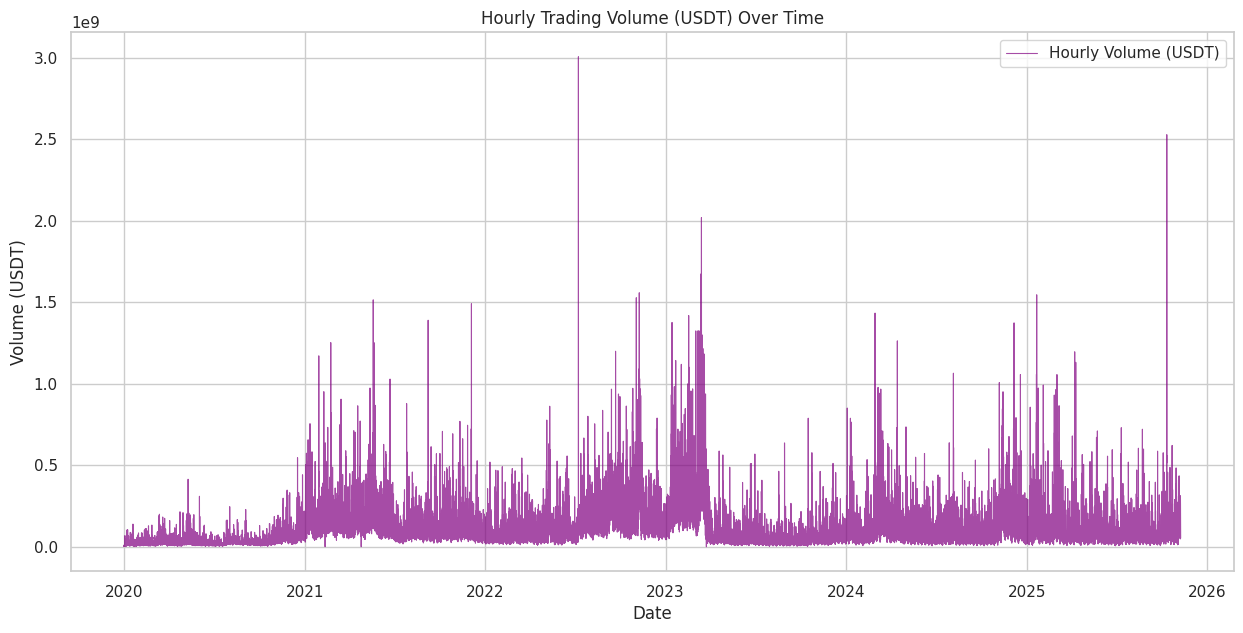

In [30]:
print("Plotting hourly trading volume over time...")
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['Volume USDT'], label='Hourly Volume (USDT)', color='purple', alpha=0.7, linewidth=0.8)
plt.title('Hourly Trading Volume (USDT) Over Time')
plt.xlabel('Date')
plt.ylabel('Volume (USDT)')
plt.legend()
plt.show()

The plot clearly shows periods of high and low trading activity, reinforcing the idea that a fixed time interval may not be the best way to sample the market.

Next, we'll examine the distribution of the volumes within the bars we created. Since we defined a fixed threshold for bar creation, we expect the volumes to be clustered around that threshold.

Plotting the distribution of volumes within the generated bars...


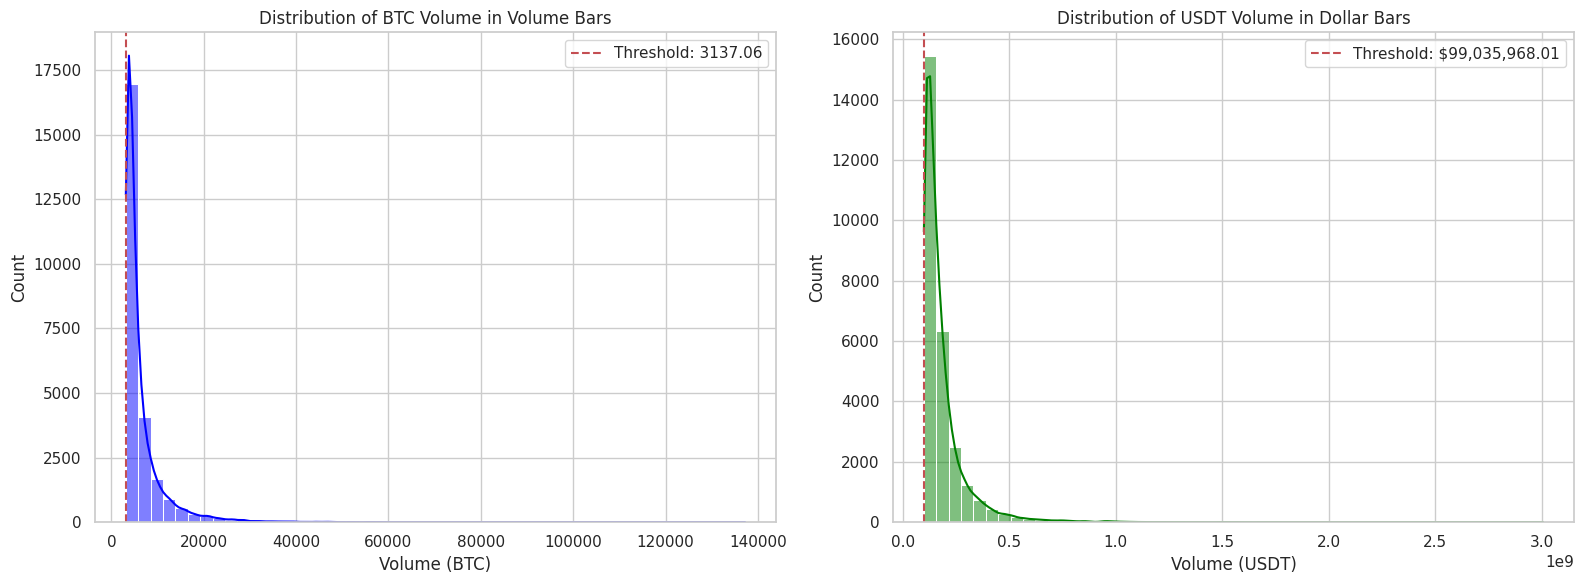

In [53]:
print("Plotting the distribution of volumes within the generated bars...")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribution of BTC volume in Volume Bars
sns.histplot(volume_bars['Volume BTC'], ax=axes[0], bins=50, kde=True, color='blue')
axes[0].set_title('Distribution of BTC Volume in Volume Bars')
axes[0].set_xlabel('Volume (BTC)')
axes[0].axvline(avg_hourly_btc_volume, color='r', linestyle='--', label=f'Threshold: {avg_hourly_btc_volume:.2f}')
axes[0].legend()

# Distribution of USDT volume in Dollar Bars
sns.histplot(dollar_bars['Volume USDT'], ax=axes[1], bins=50, kde=True, color='green')
axes[1].set_title('Distribution of USDT Volume in Dollar Bars')
axes[1].set_xlabel('Volume (USDT)')
axes[1].axvline(avg_hourly_usdt_volume, color='r', linestyle='--', label=f'Threshold: ${avg_hourly_usdt_volume:,.2f}')
axes[1].legend()

fig.tight_layout()
plt.show()

As expected, the distributions are tightly centered around the threshold values we used. The small variations occur because a bar is only formed *after* the cumulative volume crosses the threshold, so the final volume for a bar is typically slightly higher than the threshold itself.

### 7.2. Comparison of Close Prices

In [45]:
print("Plotting comparison of close prices across bar types...")
plt.figure(figsize=(15, 8))

# Plot the close prices for each bar type
plt.plot(df.index, df['close'], label='Time Bars (1-Hour)', alpha=0.6, linewidth=1)
plt.plot(volume_bars.index, volume_bars['close'], label=f'Volume Bars', alpha=0.8, linestyle='--', marker='.', markersize=2, linewidth=0.5)
plt.plot(dollar_bars.index, dollar_bars['close'], label=f'Dollar Bars', alpha=0.8, linestyle=':', marker='x', markersize=2, linewidth=0.5)

plt.title('Comparison of Close Prices: Time vs. Volume vs. Dollar Bars')
plt.xlabel('Date')
plt.ylabel('Price (USDT)')
plt.legend()
plt.show()

51280

The plot shows how volume and dollar bars sample the price series. During periods of low volatility and volume, the points for volume/dollar bars are sparse. During periods of high activity, they are clustered together, capturing more detail than fixed time bars.

### 7.3. Analysis of Bar Durations

A key feature of volume and dollar bars is their variable duration in time. Let's analyze the distribution of these durations.

Analyzing the distribution of bar durations...


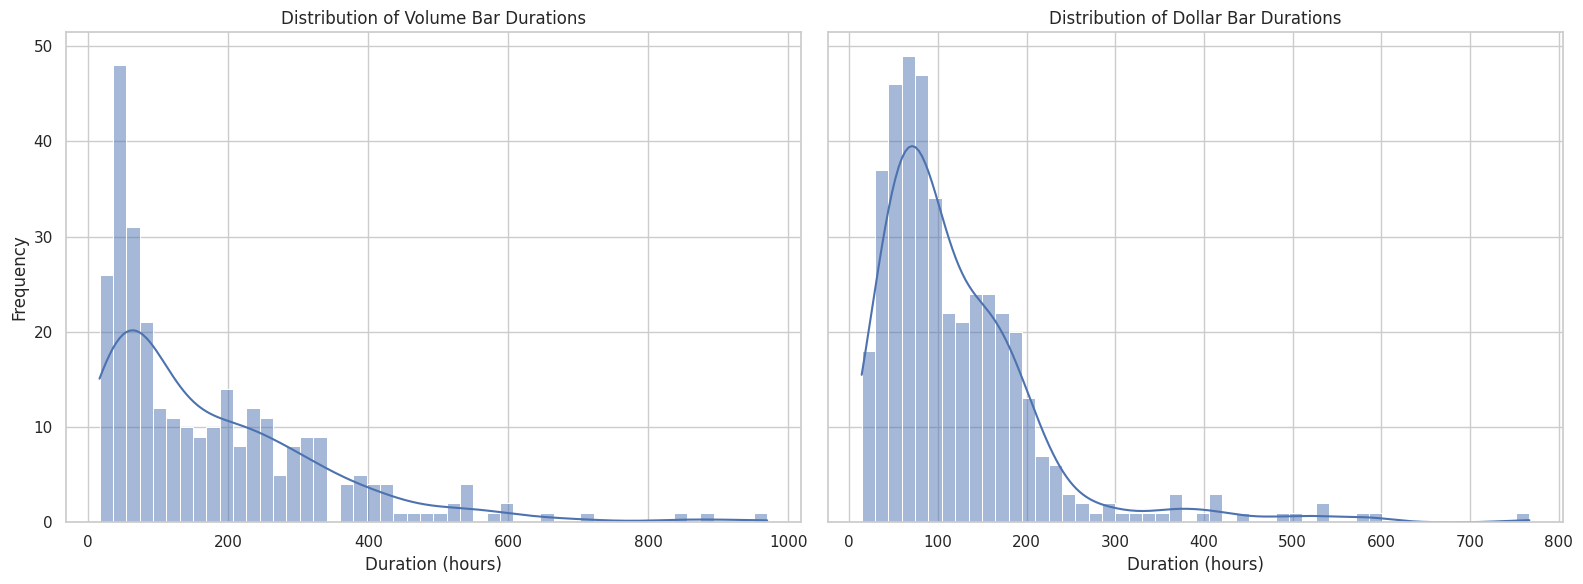

In [29]:
print("Analyzing the distribution of bar durations...")

# Calculate duration in hours for each bar
volume_bars['duration_hours'] = volume_bars.index.to_series().diff().dt.total_seconds() / 3600
dollar_bars['duration_hours'] = dollar_bars.index.to_series().diff().dt.total_seconds() / 3600

# Plot the distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

sns.histplot(volume_bars['duration_hours'].dropna(), ax=axes[0], bins=50, kde=True)
axes[0].set_title('Distribution of Volume Bar Durations')
axes[0].set_xlabel('Duration (hours)')
axes[0].set_ylabel('Frequency')

sns.histplot(dollar_bars['duration_hours'].dropna(), ax=axes[1], bins=50, kde=True)
axes[1].set_title('Distribution of Dollar Bar Durations')
axes[1].set_xlabel('Duration (hours)')

fig.tight_layout()
plt.show()

The distributions show that most bars complete in under an hour, which is expected as we used the average hourly volume as a threshold. The right-skewed tail indicates that some bars take much longer to form, corresponding to periods of very low market activity.

In [30]:
print("Descriptive statistics for bar durations (in hours):")
print("\n--- Volume Bar Duration ---")
print(volume_bars['duration_hours'].describe())
print("\n--- Dollar Bar Duration ---")
print(dollar_bars['duration_hours'].describe())

Descriptive statistics for bar durations (in hours):

--- Volume Bar Duration ---
count    289.000000
mean     176.000000
std      159.972545
min       16.000000
25%       53.000000
50%      125.000000
75%      250.000000
max      970.000000
Name: duration_hours, dtype: float64

--- Dollar Bar Duration ---
count    417.000000
mean     121.462830
std       94.642237
min       14.000000
25%       60.000000
50%       93.000000
75%      160.000000
max      767.000000
Name: duration_hours, dtype: float64


## 8. Statistical Properties of Returns for Different Bar Types

A key motivation for using alternative bars (like volume or dollar bars) is that they may produce returns series with better statistical properties—closer to being independent and identically distributed (i.i.d.) Gaussian. This is desirable for many financial models.

We will now analyze and compare the following properties for returns calculated from time, volume, and dollar bars:
1.  **Gaussian Distribution**: How close are the returns to a normal distribution? We'll check skewness, kurtosis, and perform a Jarque-Bera test.
2.  **Serial Correlation**: Are the returns independent of each other? We'll use the Ljung-Box test to check for autocorrelation.
3.  **Homoscedasticity**: Is the variance of returns constant over time? We will use Levene's test to compare the variance of the first and second halves of the data.

In [58]:
def analyze_returns_properties(returns: pd.Series, bar_type: str):
    """
    Performs and prints a statistical analysis of a returns series.
    """
    print(f"\n--- Analysis of Returns for {bar_type} ---")
    returns = returns.dropna()
    if len(returns) < 20:
        print("  - Not enough data points for analysis.")
        print("-" * 50)
        return

    # 1. Gaussian Distribution Properties
    print("\n1. Gaussian Distribution Properties:")
    jb_test = stats.jarque_bera(returns)
    print(f"  - Skewness: {returns.skew():.4f}")
    print(f"  - Kurtosis: {returns.kurtosis():.4f} (Excess kurtosis)")
    print(f"  - Jarque-Bera Test Statistic: {jb_test.statistic:.4f}, p-value: {jb_test.pvalue:.4f}")
    if jb_test.pvalue < 0.05:
        print("  - Result: The distribution is likely non-Gaussian (p-value < 0.05).")
    else:
        print("  - Result: The distribution may be Gaussian (p-value >= 0.05).")

    # 2. Serial Correlation (Autocorrelation)
    print("\n2. Serial Correlation (Ljung-Box Test):")
    # Ensure there are enough observations for the test
    lags = min(10, len(returns) // 5)
    if lags > 0:
        lb_test = acorr_ljungbox(returns, lags=[lags], return_df=True)
        p_value = lb_test['lb_pvalue'].iloc[0]
        print(f"  - Ljung-Box p-value (lag {lags}): {p_value:.4f}")
        if p_value < 0.05:
            print("  - Result: Significant serial correlation detected (p-value < 0.05).")
        else:
            print("  - Result: No significant serial correlation detected (p-value >= 0.05).")
    else:
        print("  - Not enough data to perform Ljung-Box test.")

    # 3. Homoscedasticity (Variability over time) using Levene's test
    print("\n3. Homoscedasticity (Levene's Test):")
    mid_point = len(returns) // 2
    part1 = returns.iloc[:mid_point]
    part2 = returns.iloc[mid_point:]
    if len(part1) > 5 and len(part2) > 5:
        levene_test = stats.levene(part1, part2)
        print(f"  - Levene Test Statistic: {levene_test.statistic:.4f}, p-value: {levene_test.pvalue:.4f}")
        if levene_test.pvalue < 0.05:
            print("  - Result: The variances are unequal (heteroscedastic, p-value < 0.05).")
        else:
            print("  - Result: The variances are equal (homoscedastic, p-value >= 0.05).")
    else:
        print("  - Not enough data to perform Levene's test.")

    print("-" * 50)

### 8.1. Analysis of Time Bar Returns (Baseline)

In [6]:
time_bar_returns = df['close'].pct_change()
analyze_returns_properties(time_bar_returns, "1-Hour Time Bars")


--- Analysis of Returns for 1-Hour Time Bars ---

1. Gaussian Distribution Properties:
  - Skewness: -0.4223
  - Kurtosis: 48.4905 (Excess kurtosis)
  - Jarque-Bera Test Statistic: 5024424.3873, p-value: 0.0000
  - Result: The distribution is likely non-Gaussian (p-value < 0.05).

2. Serial Correlation (Ljung-Box Test):
  - Ljung-Box p-value (lag 10): 0.0000
  - Result: Significant serial correlation detected (p-value < 0.05).

3. Homoscedasticity (Levene's Test):
  - Levene Test Statistic: 1595.0997, p-value: 0.0000
  - Result: The variances are unequal (heteroscedastic, p-value < 0.05).
--------------------------------------------------


### 8.2. Analysis of Volume Bar Returns

We'll analyze returns from volume bars created using three different thresholds: the mean hourly volume, the 75th percentile, and the 90th percentile.

In [9]:
print("\nAnalyzing statistical properties of Volume Bar returns...")

volume_thresholds = {
    'Mean': df['Volume BTC'].mean(),
    '75th Percentile': df['Volume BTC'].quantile(0.75),
    '90th Percentile': df['Volume BTC'].quantile(0.90)
}

for label, threshold in volume_thresholds.items():
    bars = create_volume_bars(df_for_bars, volume_threshold=threshold)
    returns = bars['close'].pct_change()
    bar_label = f"Volume Bars ({label} Threshold: {threshold:.2f} BTC)"
    analyze_returns_properties(returns, bar_label)


Analyzing statistical properties of Volume Bar returns...

--- Analysis of Returns for Volume Bars (Mean Threshold: 3137.06 BTC) ---

1. Gaussian Distribution Properties:
  - Skewness: -0.3007
  - Kurtosis: 23.3265 (Excess kurtosis)
  - Jarque-Bera Test Statistic: 572265.3557, p-value: 0.0000
  - Result: The distribution is likely non-Gaussian (p-value < 0.05).

2. Serial Correlation (Ljung-Box Test):
  - Ljung-Box p-value (lag 10): 0.0006
  - Result: Significant serial correlation detected (p-value < 0.05).

3. Homoscedasticity (Levene's Test):
  - Levene Test Statistic: 805.3975, p-value: 0.0000
  - Result: The variances are unequal (heteroscedastic, p-value < 0.05).
--------------------------------------------------

--- Analysis of Returns for Volume Bars (75th Percentile Threshold: 3421.05 BTC) ---

1. Gaussian Distribution Properties:
  - Skewness: -0.2976
  - Kurtosis: 22.4008 (Excess kurtosis)
  - Jarque-Bera Test Statistic: 502513.7418, p-value: 0.0000
  - Result: The distrib

### 8.3. Analysis of Dollar Bar Returns

We'll do the same analysis for dollar bars, using thresholds based on the mean, 75th, and 90th percentiles of hourly USDT volume.

In [19]:
print("\nAnalyzing statistical properties of Dollar Bar returns...")

dollar_thresholds = {
    'Mean': df['Volume USDT'].mean(),
    '75th Percentile': df['Volume USDT'].quantile(0.75),
    '90th Percentile': df['Volume USDT'].quantile(0.90)
}

for label, threshold in dollar_thresholds.items():
    bars = create_dollar_bars(df_for_bars, dollar_threshold=threshold)
    returns = bars['close'].pct_change()
    bar_label = f"Dollar Bars ({label} Threshold: ${threshold:,.0f})"
    analyze_returns_properties(returns, bar_label)


Analyzing statistical properties of Dollar Bar returns...

--- Analysis of Returns for Dollar Bars (Mean Threshold: $99,035,968) ---

1. Gaussian Distribution Properties:
  - Skewness: -0.3894
  - Kurtosis: 25.9858 (Excess kurtosis)
  - Jarque-Bera Test Statistic: 776952.4836, p-value: 0.0000
  - Result: The distribution is likely non-Gaussian (p-value < 0.05).

2. Serial Correlation (Ljung-Box Test):
  - Ljung-Box p-value (lag 10): 0.0000
  - Result: Significant serial correlation detected (p-value < 0.05).

3. Homoscedasticity (Levene's Test):
  - Levene Test Statistic: 993.8739, p-value: 0.0000
  - Result: The variances are unequal (heteroscedastic, p-value < 0.05).
--------------------------------------------------

--- Analysis of Returns for Dollar Bars (75th Percentile Threshold: $123,674,254) ---

1. Gaussian Distribution Properties:
  - Skewness: -0.4701
  - Kurtosis: 18.6253 (Excess kurtosis)
  - Jarque-Bera Test Statistic: 350369.3366, p-value: 0.0000
  - Result: The distri

### 8.4. Summary of Findings

This analysis typically shows that as we move from time-based sampling to activity-based sampling (volume/dollar bars), the resulting returns series often exhibit weaker serial correlation and become closer to a Gaussian distribution (i.e., lower kurtosis). This makes them a more suitable input for many standard financial models that assume i.i.d. returns. However, heteroscedasticity (non-constant variance) often remains a persistent feature in financial data, regardless of the bar type.

## 9. Threshold Sweep Analysis for Statistical Properties

To understand how the choice of threshold affects the statistical properties of returns, we will perform a sweep across a range of thresholds for both volume and dollar bars. We will start from the mean hourly value and go up to four times the maximum observed hourly value.

For each threshold, we will compute the same statistical properties as before and plot them. This will help us identify if there are optimal threshold regions where the returns series is "best behaved" (e.g., lowest kurtosis, highest p-value for normality tests, etc.).

### 9.1. Helper Functions for Threshold Sweep

In [8]:
def get_returns_properties(returns: pd.Series):
    """
    Calculates statistical properties of a returns series.
    Returns a dictionary of results, or NaNs if data is insufficient.
    """
    returns = returns.dropna()
    if len(returns) < 20:
        return {
            'skew': np.nan, 'kurtosis': np.nan, 'jb_pvalue': np.nan,
            'lb_pvalue': np.nan, 'levene_pvalue': np.nan, 'num_bars': len(returns)
        }

    # Gaussian properties
    skew = returns.skew()
    kurtosis = returns.kurtosis()
    jb_test = stats.jarque_bera(returns)
    jb_pvalue = jb_test.pvalue

    # Serial correlation
    lags = min(10, len(returns) // 5)
    lb_pvalue = np.nan
    if lags > 0:
        lb_test = acorr_ljungbox(returns, lags=[lags], return_df=True)
        lb_pvalue = lb_test['lb_pvalue'].iloc[0]

    # Homoscedasticity
    mid_point = len(returns) // 2
    part1 = returns.iloc[:mid_point]
    part2 = returns.iloc[mid_point:]
    levene_pvalue = np.nan
    if len(part1) > 5 and len(part2) > 5:
        levene_test = stats.levene(part1, part2)
        levene_pvalue = levene_test.pvalue

    return {
        'skew': skew, 'kurtosis': kurtosis, 'jb_pvalue': jb_pvalue,
        'lb_pvalue': lb_pvalue, 'levene_pvalue': levene_pvalue, 'num_bars': len(returns)
    }


def plot_threshold_sweep_analysis(
    df_for_bars: pd.DataFrame,
    bar_creation_func,
    metric_series: pd.Series,
    sweep_title: str,
    num_steps: int = 50
):
    """
    Performs a sweep of thresholds for a bar creation function and plots the statistical
    properties of the resulting returns series.
    """
    print(f"\n--- Starting Threshold Sweep Analysis for {sweep_title} ---")
    
    # Define threshold range
    min_threshold = metric_series.mean()
    max_threshold = metric_series.max() * 4
    thresholds = np.linspace(min_threshold, max_threshold, num_steps)
    
    results = []
    
    # Using tqdm for progress bar
    from tqdm.notebook import tqdm
    
    for threshold in tqdm(thresholds, desc=f"Sweeping {sweep_title}"):
        if threshold <= 0: continue
        
        bars = bar_creation_func(df_for_bars, threshold)
        returns = bars['close'].pct_change()
        
        stats_dict = get_returns_properties(returns)
        stats_dict['threshold'] = threshold
        results.append(stats_dict)
        
    results_df = pd.DataFrame(results).dropna()
    
    if results_df.empty:
        print("Could not generate sufficient data for plotting.")
        return

    # Plotting
    print(f"Plotting results for {sweep_title}...")
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    fig.suptitle(f'Statistical Properties of Returns vs. Threshold for {sweep_title}', fontsize=16)
    axes = axes.flatten()

    # Plot Skewness and Kurtosis
    axes[0].plot(results_df['threshold'], results_df['skew'], marker='.', linestyle='-')
    axes[0].set_title('Skewness vs. Threshold')
    axes[0].set_xlabel('Threshold')
    axes[0].set_ylabel('Skewness')
    axes[0].grid(True)
    
    axes[1].plot(results_df['threshold'], results_df['kurtosis'], marker='.', linestyle='-')
    axes[1].set_title('Excess Kurtosis vs. Threshold')
    axes[1].set_xlabel('Threshold')
    axes[1].set_ylabel('Kurtosis')
    axes[1].grid(True)
    
    # Plot p-values
    axes[2].plot(results_df['threshold'], results_df['jb_pvalue'], marker='.', linestyle='-')
    axes[2].axhline(y=0.05, color='r', linestyle='--', label='p=0.05')
    axes[2].set_title('Jarque-Bera p-value vs. Threshold')
    axes[2].set_xlabel('Threshold')
    axes[2].set_ylabel('p-value')
    axes[2].legend()
    axes[2].grid(True)

    axes[3].plot(results_df['threshold'], results_df['lb_pvalue'], marker='.', linestyle='-')
    axes[3].axhline(y=0.05, color='r', linestyle='--', label='p=0.05')
    axes[3].set_title('Ljung-Box p-value vs. Threshold')
    axes[3].set_xlabel('Threshold')
    axes[3].set_ylabel('p-value')
    axes[3].legend()
    axes[3].grid(True)

    axes[4].plot(results_df['threshold'], results_df['levene_pvalue'], marker='.', linestyle='-')
    axes[4].axhline(y=0.05, color='r', linestyle='--', label='p=0.05')
    axes[4].set_title("Levene's Test p-value vs. Threshold")
    axes[4].set_xlabel('Threshold')
    axes[4].set_ylabel('p-value')
    axes[4].legend()
    axes[4].grid(True)
    
    # Plot number of bars
    axes[5].plot(results_df['threshold'], results_df['num_bars'], marker='.', linestyle='-')
    axes[5].set_title('Number of Bars vs. Threshold')
    axes[5].set_xlabel('Threshold')
    axes[5].set_ylabel('Number of Bars')
    axes[5].grid(True)
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

### 9.2. Volume Bar Threshold Sweep


--- Starting Threshold Sweep Analysis for Volume Bars (BTC) ---
Plotting results for Volume Bars (BTC)...


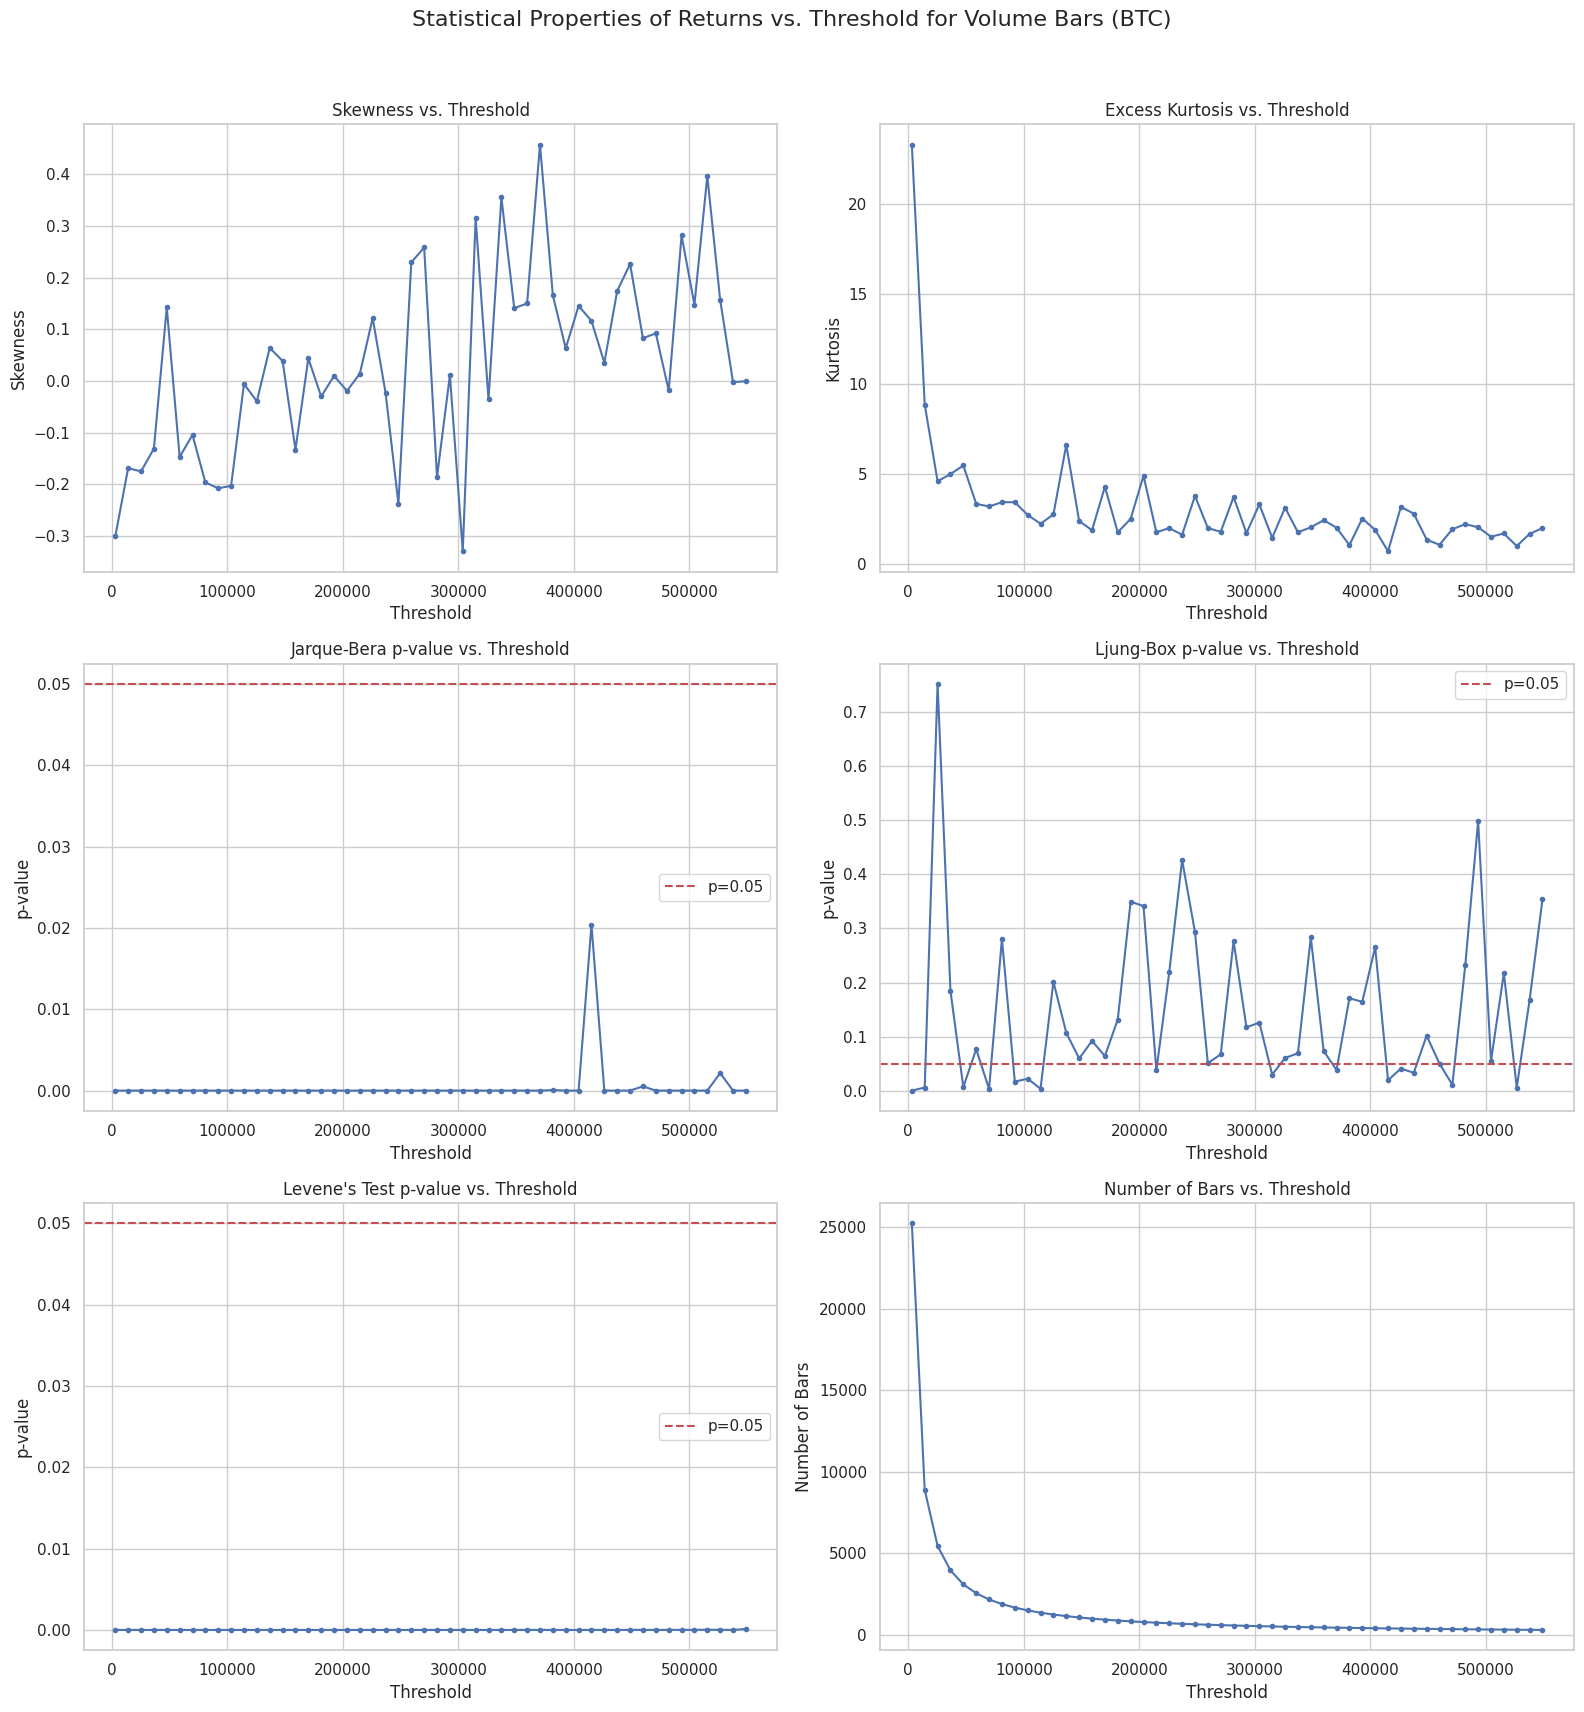

In [10]:
plot_threshold_sweep_analysis(
    df_for_bars=df_for_bars,
    bar_creation_func=create_volume_bars,
    metric_series=df['Volume BTC'],
    sweep_title="Volume Bars (BTC)"
)

### 9.3. Dollar Bar Threshold Sweep


--- Starting Threshold Sweep Analysis for Dollar Bars (USDT) ---
Plotting results for Dollar Bars (USDT)...


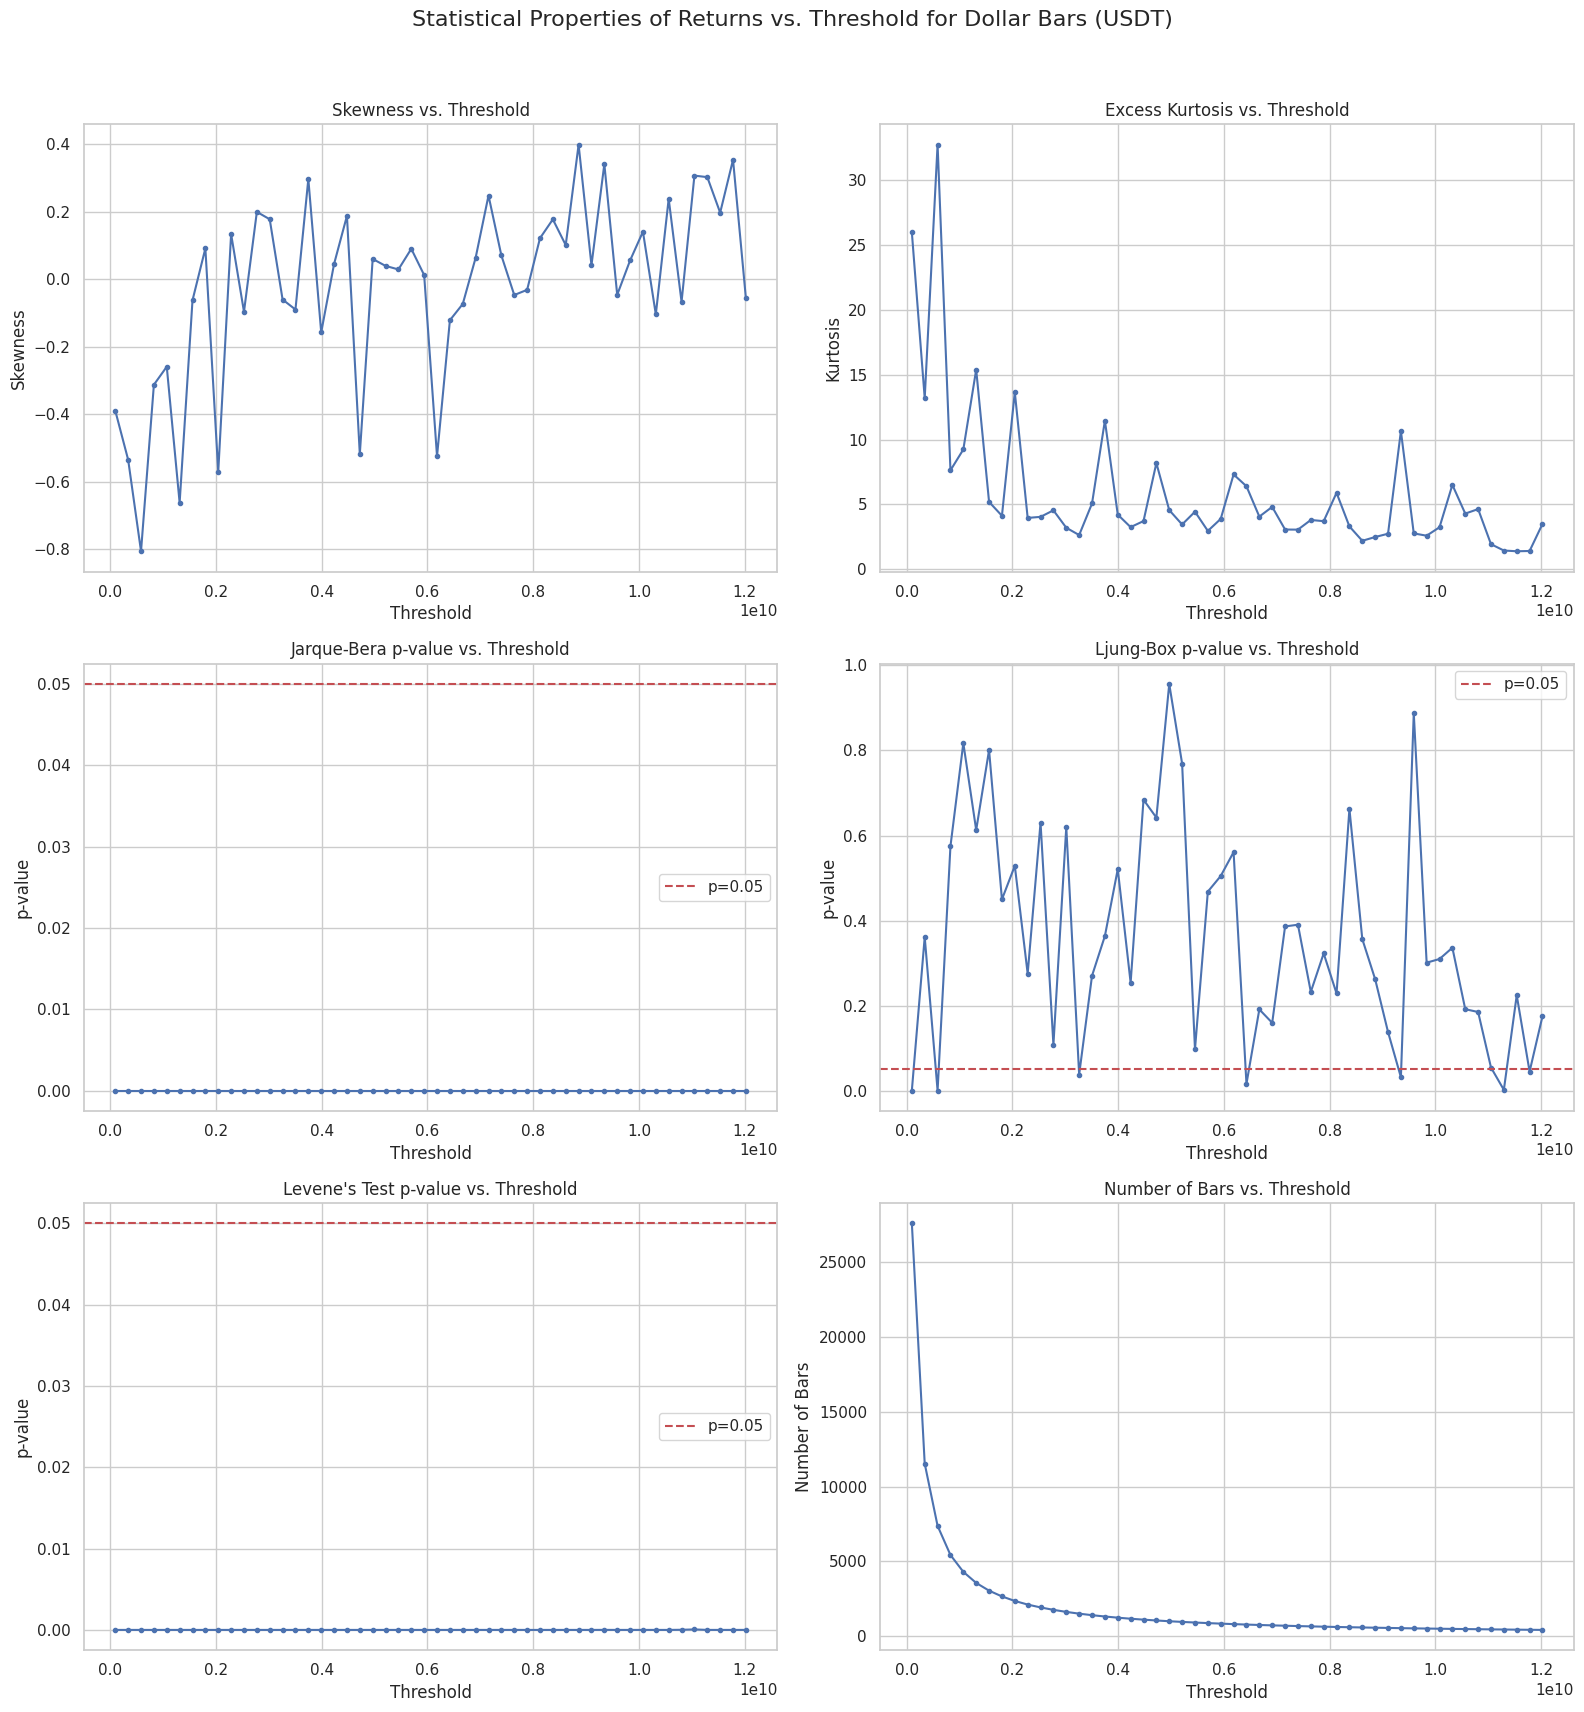

In [11]:
plot_threshold_sweep_analysis(
    df_for_bars=df_for_bars,
    bar_creation_func=create_dollar_bars,
    metric_series=df['Volume USDT'],
    sweep_title="Dollar Bars (USDT)"
)

### 9.4. Price Change Bar Threshold Sweep


--- Starting Threshold Sweep Analysis for Price Change Bars ---
Plotting results for Price Change Bars...


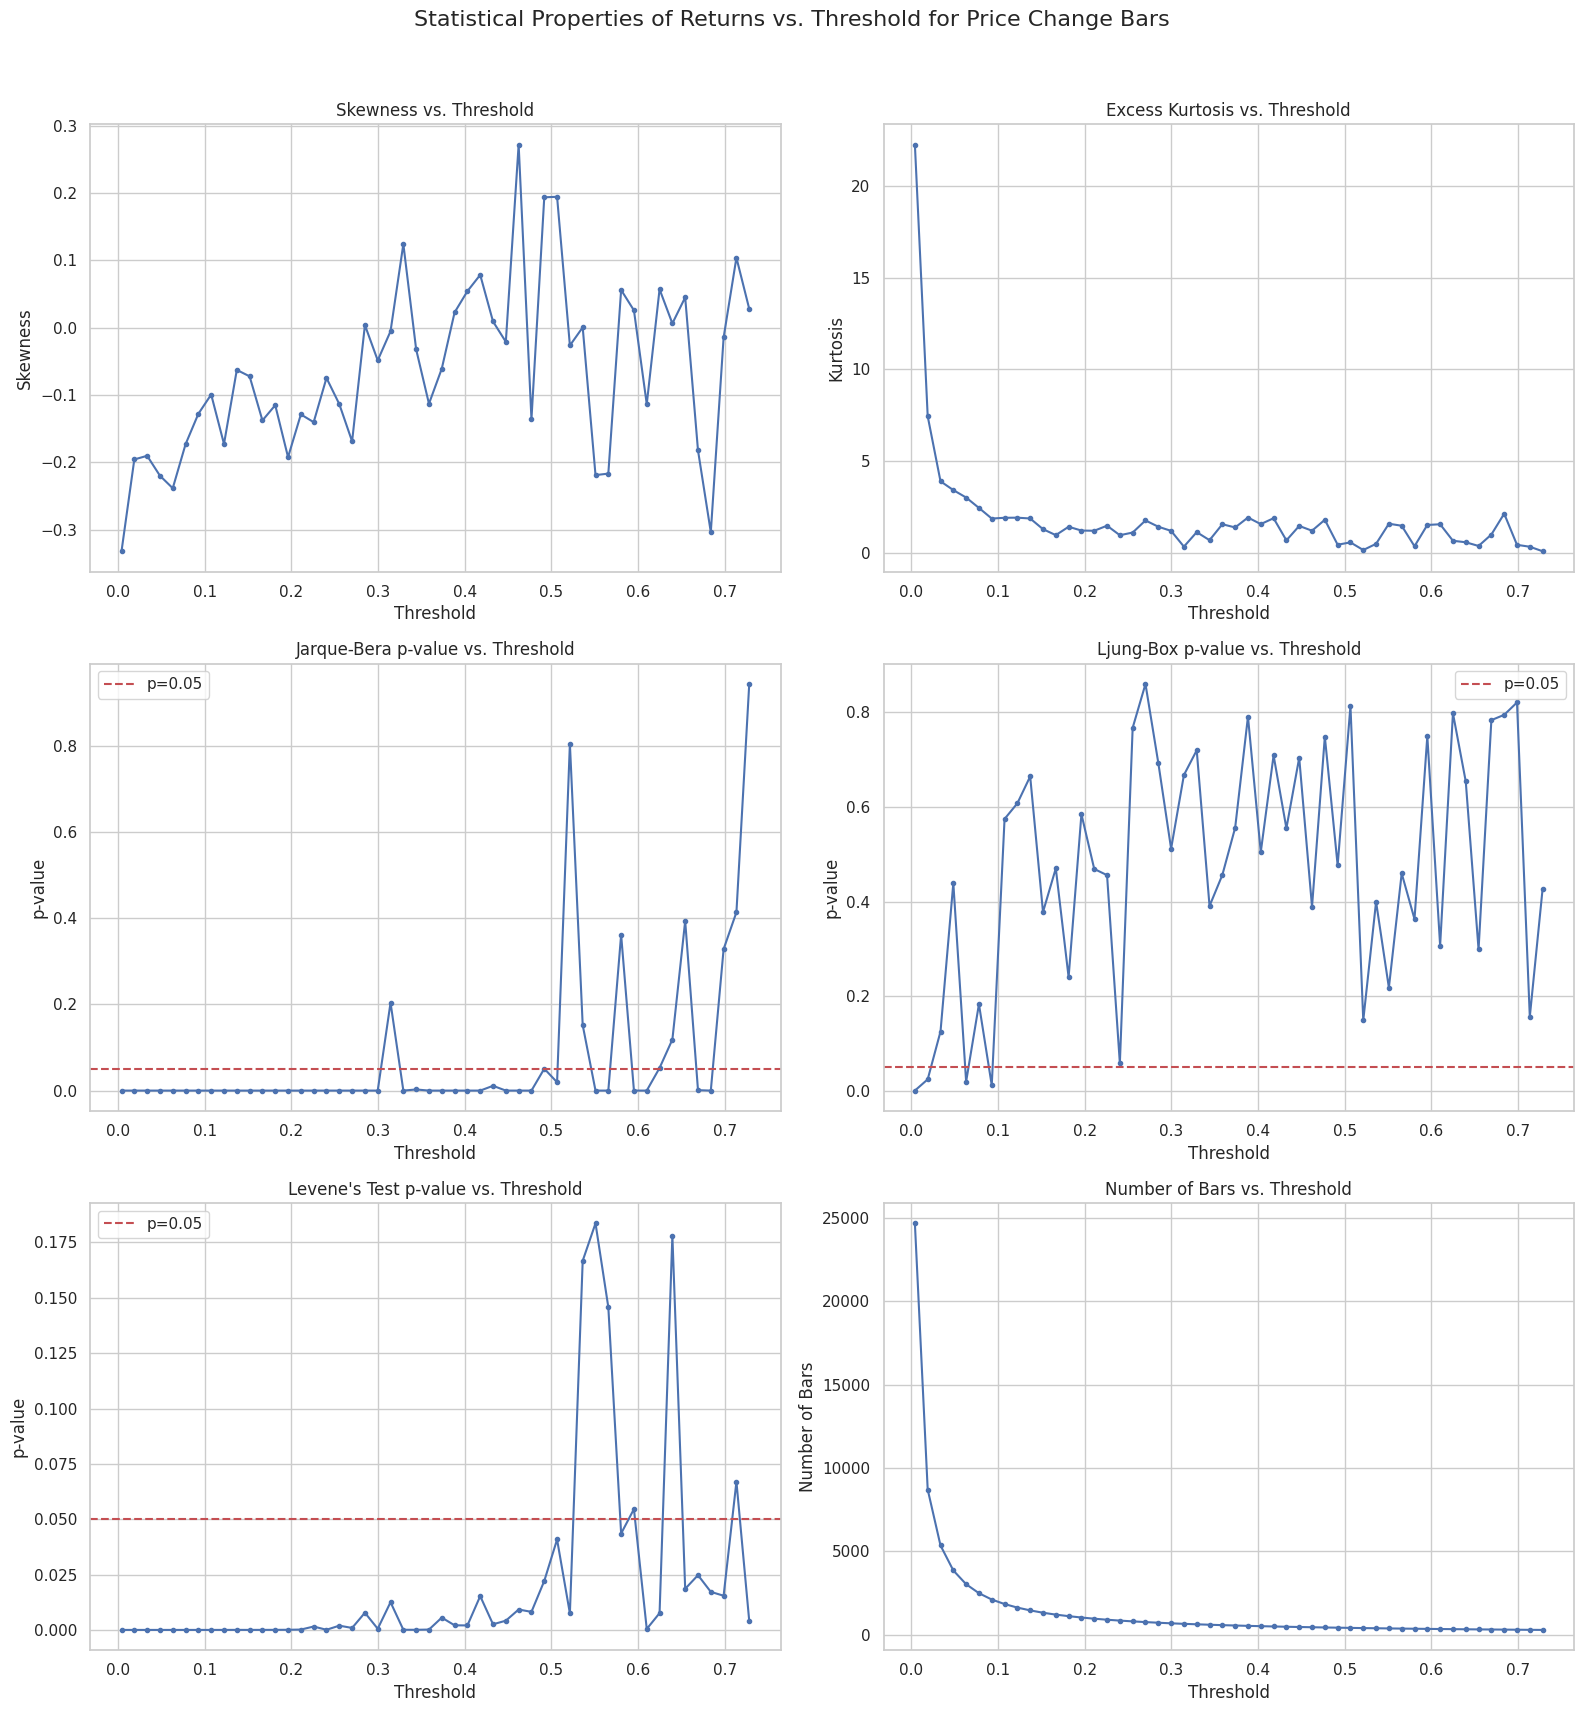

In [11]:
# Calculate absolute fractional price change to use for the metric series
abs_frac_change = df['close'].pct_change().abs().dropna()

plot_threshold_sweep_analysis(
    df_for_bars=df_for_bars,
    bar_creation_func=create_price_change_bars,
    metric_series=abs_frac_change,
    sweep_title="Price Change Bars"
)

### 9.5. Analysis of Tick Imbalance Bar Returns

Finally, we'll analyze the returns from Tick Imbalance Bars (TIBs). These bars are formed based on the cumulative imbalance of tick signs (+1 for upticks, -1 for downticks), using a dynamic threshold based on the expected imbalance. This method is designed to adapt to changes in market order flow.

Note: We are applying this to 1-hour data, where each bar is treated as a single "tick". This analysis is more powerful when applied to high-frequency tick data.

In [189]:
print("\nAnalyzing statistical properties of Tick Imbalance Bar returns...")

# Create Tick Imbalance Bars from the hourly data.
# We'll use an initial bar size estimate of 24 hours (1 day) as a starting point,
# as the default of 1 would lead to a bar per tick.
tick_imbalance_bars, thresholds, cum_imb = create_tick_imbalance_bars(
    df_for_bars,
    threshold_type="dynamic_runs",
    initial_bar_size_estimate=24,
    window_run_length=20
)

if not tick_imbalance_bars.empty:
    returns = tick_imbalance_bars['close'].pct_change()
    analyze_returns_properties(returns, "Tick Imbalance Bars (from 1-hour data)")
else:
    print("Could not create Tick Imbalance Bars, possibly due to insufficient data.")


Analyzing statistical properties of Tick Imbalance Bar returns...

--- Analysis of Returns for Tick Imbalance Bars (from 1-hour data) ---

1. Gaussian Distribution Properties:
  - Skewness: -0.0615
  - Kurtosis: 34.3530 (Excess kurtosis)
  - Jarque-Bera Test Statistic: 1442860.2869, p-value: 0.0000
  - Result: The distribution is likely non-Gaussian (p-value < 0.05).

2. Serial Correlation (Ljung-Box Test):
  - Ljung-Box p-value (lag 10): 0.0000
  - Result: Significant serial correlation detected (p-value < 0.05).

3. Homoscedasticity (Levene's Test):
  - Levene Test Statistic: 785.9931, p-value: 0.0000
  - Result: The variances are unequal (heteroscedastic, p-value < 0.05).
--------------------------------------------------


In [163]:
thresholds

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
51275    1.0
51276    1.0
51277    1.0
51278    1.0
51279    1.0
Length: 51280, dtype: float64

Plotting Tick Imbalance Bar sampling process...


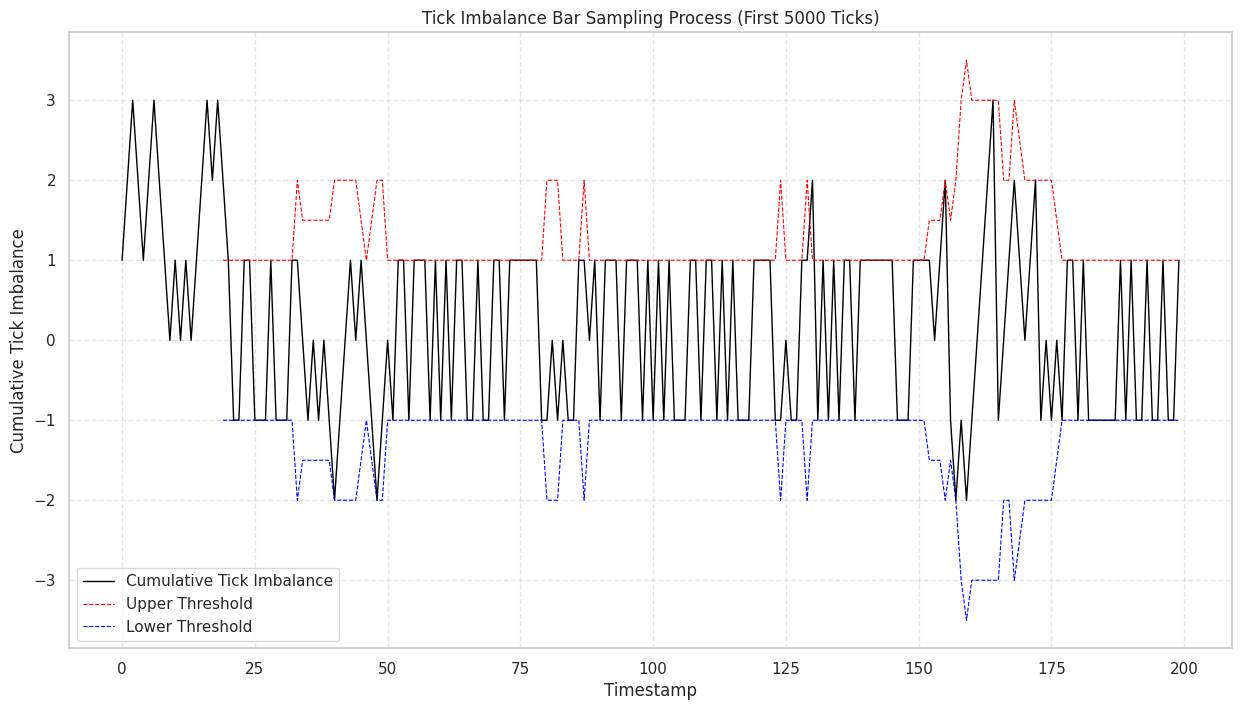

In [192]:
import datetime
# Plot the cumulative imbalance, the dynamic thresholds, and the bar sampling points
if not tick_imbalance_bars.empty:
    print("Plotting Tick Imbalance Bar sampling process...")

    # Limit plot to a smaller window for readability if the dataset is large
    plot_window = df_for_bars.index[:200] # Plot first ~5000 data points

    plt.figure(figsize=(15, 8))
    
    # Plot cumulative imbalance
    plt.plot(plot_window, cum_imb.loc[plot_window], label='Cumulative Tick Imbalance', color='black', linewidth=1)
    
    # Plot dynamic thresholds
    plt.plot(plot_window, thresholds.loc[plot_window], label='Upper Threshold', color='red', linestyle='--', linewidth=0.8)
    plt.plot(plot_window, -thresholds.loc[plot_window], label='Lower Threshold', color='blue', linestyle='--', linewidth=0.8)

    # Mark the points where bars were sampled
    sample_points = tick_imbalance_bars.index
    sample_points_in_window = sample_points[sample_points.isin(plot_window)]
    
    if not sample_points_in_window.empty:
        plt.scatter(
            sample_points_in_window, 
            cum_imb.loc[sample_points_in_window], 
            color='lime', 
            marker='o', 
            s=50, 
            label='Bar Sampled',
            zorder=5 # Plot on top
        )

    plt.title('Tick Imbalance Bar Sampling Process (First 5000 Ticks)')
    plt.xlabel('Timestamp')
    plt.ylabel('Cumulative Tick Imbalance')
    plt.legend()
    # plt.xlim(datetime.datetime(2023,1,1), datetime.datetime(2024,1,1))
    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.show()
else:
    print("No Tick Imbalance Bars were created, skipping plot.")

In [131]:
def _get_signed_ticks(price_series: pd.Series) -> pd.Series:
    """
    Computes tick signs based on price changes.
    +1 for an uptick, -1 for a downtick.
    If price is unchanged, the previous sign is carried forward.
    """
    price_diffs = price_series.diff()
    tick_signs = price_diffs.copy()
    tick_signs.loc[price_diffs > 0] = 1
    tick_signs.loc[price_diffs < 0] = -1
    tick_signs.loc[price_diffs == 0] = None
    tick_signs = tick_signs.ffill()
    # Fill the first potential NaN with 1 (assuming an initial uptick)
    tick_signs = tick_signs.fillna(1).astype(int)
    return tick_signs

def get_run_metrics(tick_signs: pd.Series, quantiles=[0.25, 0.5, 0.75, 0.9, 0.99]):
    """
    Calculates run lengths and returns their quantiles.
    """
    # 1. Identify where the value changes compared to the previous one
    # True if value changes, False if it stays the same
    changes = tick_signs != tick_signs.shift()
    
    # 2. Create a group ID using cumulative sum
    # This increments the ID every time 'changes' is True
    group_ids = changes.cumsum()
    
    # 3. Group by this ID and count the size of each run
    # We also take 'first' to know if the run was Positive (1) or Negative (-1)
    runs = tick_signs.groupby(group_ids).agg(['count', 'first'])
    runs.columns = ['length', 'sign']
    
    # 4. Calculate Quantiles
    # Overall quantiles
    overall_quantiles = runs['length'].quantile(quantiles)
    
    # Split by direction (useful to see if downtick runs are longer than uptick runs)
    pos_quantiles = runs[runs['sign'] == 1]['length'].quantile(quantiles)
    neg_quantiles = runs[runs['sign'] == -1]['length'].quantile(quantiles)
    
    return {
        "runs_df": runs, # The raw data if you need it
        "overall_quantiles": overall_quantiles,
        "positive_quantiles": pos_quantiles,
        "negative_quantiles": neg_quantiles
    }

# --- Example Usage ---

# Generate dummy price data (Random Walk)
np.random.seed(42)
prices = pd.Series(np.cumsum(np.random.randn(10000))) + 100

# 1. Get Signs
signs = _get_signed_ticks(prices)

# 2. Get Run Analysis
metrics = get_run_metrics(signs)

print("--- Overall Run Length Quantiles ---")
print(metrics['overall_quantiles'])
print("\n--- Uptick Run Quantiles ---")
print(metrics['positive_quantiles'])
print("\n--- Downtick Run Quantiles ---")
print(metrics['negative_quantiles'])

--- Overall Run Length Quantiles ---
0.25    1.0
0.50    2.0
0.75    2.0
0.90    4.0
0.99    7.0
Name: length, dtype: float64

--- Uptick Run Quantiles ---
0.25    1.0
0.50    2.0
0.75    2.0
0.90    4.0
0.99    7.0
Name: length, dtype: float64

--- Downtick Run Quantiles ---
0.25    1.0
0.50    1.0
0.75    2.0
0.90    4.0
0.99    7.0
Name: length, dtype: float64


In [186]:
changes = tick_signs != tick_signs.shift()
group_ids = changes.cumsum()

def compute_quantile(window):
    runs = window.groupby(group_ids).agg(["count", "first"])
    runs.columns = ["length", "sign"]
    return runs["length"].quantile(.50)

dynamic_run_thresholds = group_ids.rolling(20).apply(
    compute_quantile
)

<Axes: >

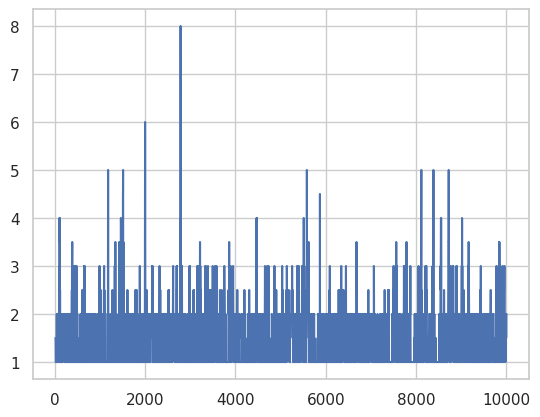

In [187]:
dynamic_run_thresholds.plot()

## 10. Threshold Sweep Analysis on 1-Minute Data

We will now repeat the entire threshold sweep analysis using 1-minute resolution data. This higher frequency data will allow us to see if the same patterns hold and how the much smaller time interval affects the choice of thresholds and the resulting statistical properties.

In [25]:
print("\n--- Starting Analysis on 1-Minute Data ---")

# --- 1. Load and Prepare 1-Minute Data ---
DATA_PATH_1M = '/home/leocenturion/Documents/postgrados/ia/tp-final/Tp Final/data/binance/python/data/spot/monthly/klines/BTCUSDT/1m/BTCUSDT_consolidated_klines.csv'
print(f"Loading 1-minute data from: {DATA_PATH_1M}")
df_1m = pd.read_csv(DATA_PATH_1M)

# Convert to datetime and set as index
# The consolidation script already creates a 'date' column for the index.
df_1m['timestamp'] = pd.to_datetime(df_1m['date'], format='ISO8601')
df_1m.set_index('timestamp', inplace=True)
df_1m.sort_index(inplace=True)
df_1m.drop(columns=['date'], inplace=True)

print("1-minute data loaded and prepared. Shape:", df_1m.shape)

# Create the DataFrame for bar creation functions
df_for_bars_1m = df_1m.reset_index().rename(columns={'timestamp': 'date'})


--- Starting Analysis on 1-Minute Data ---
Loading 1-minute data from: /home/leocenturion/Documents/postgrados/ia/tp-final/Tp Final/data/binance/python/data/spot/monthly/klines/BTCUSDT/1m/BTCUSDT_consolidated_klines.csv
1-minute data loaded and prepared. Shape: (3870559, 12)


### 10.1. Volume Bar Threshold Sweep (1-Minute Data)


--- Starting Threshold Sweep Analysis for Volume Bars (BTC) from 1-Minute Data ---
Plotting results for Volume Bars (BTC) from 1-Minute Data...


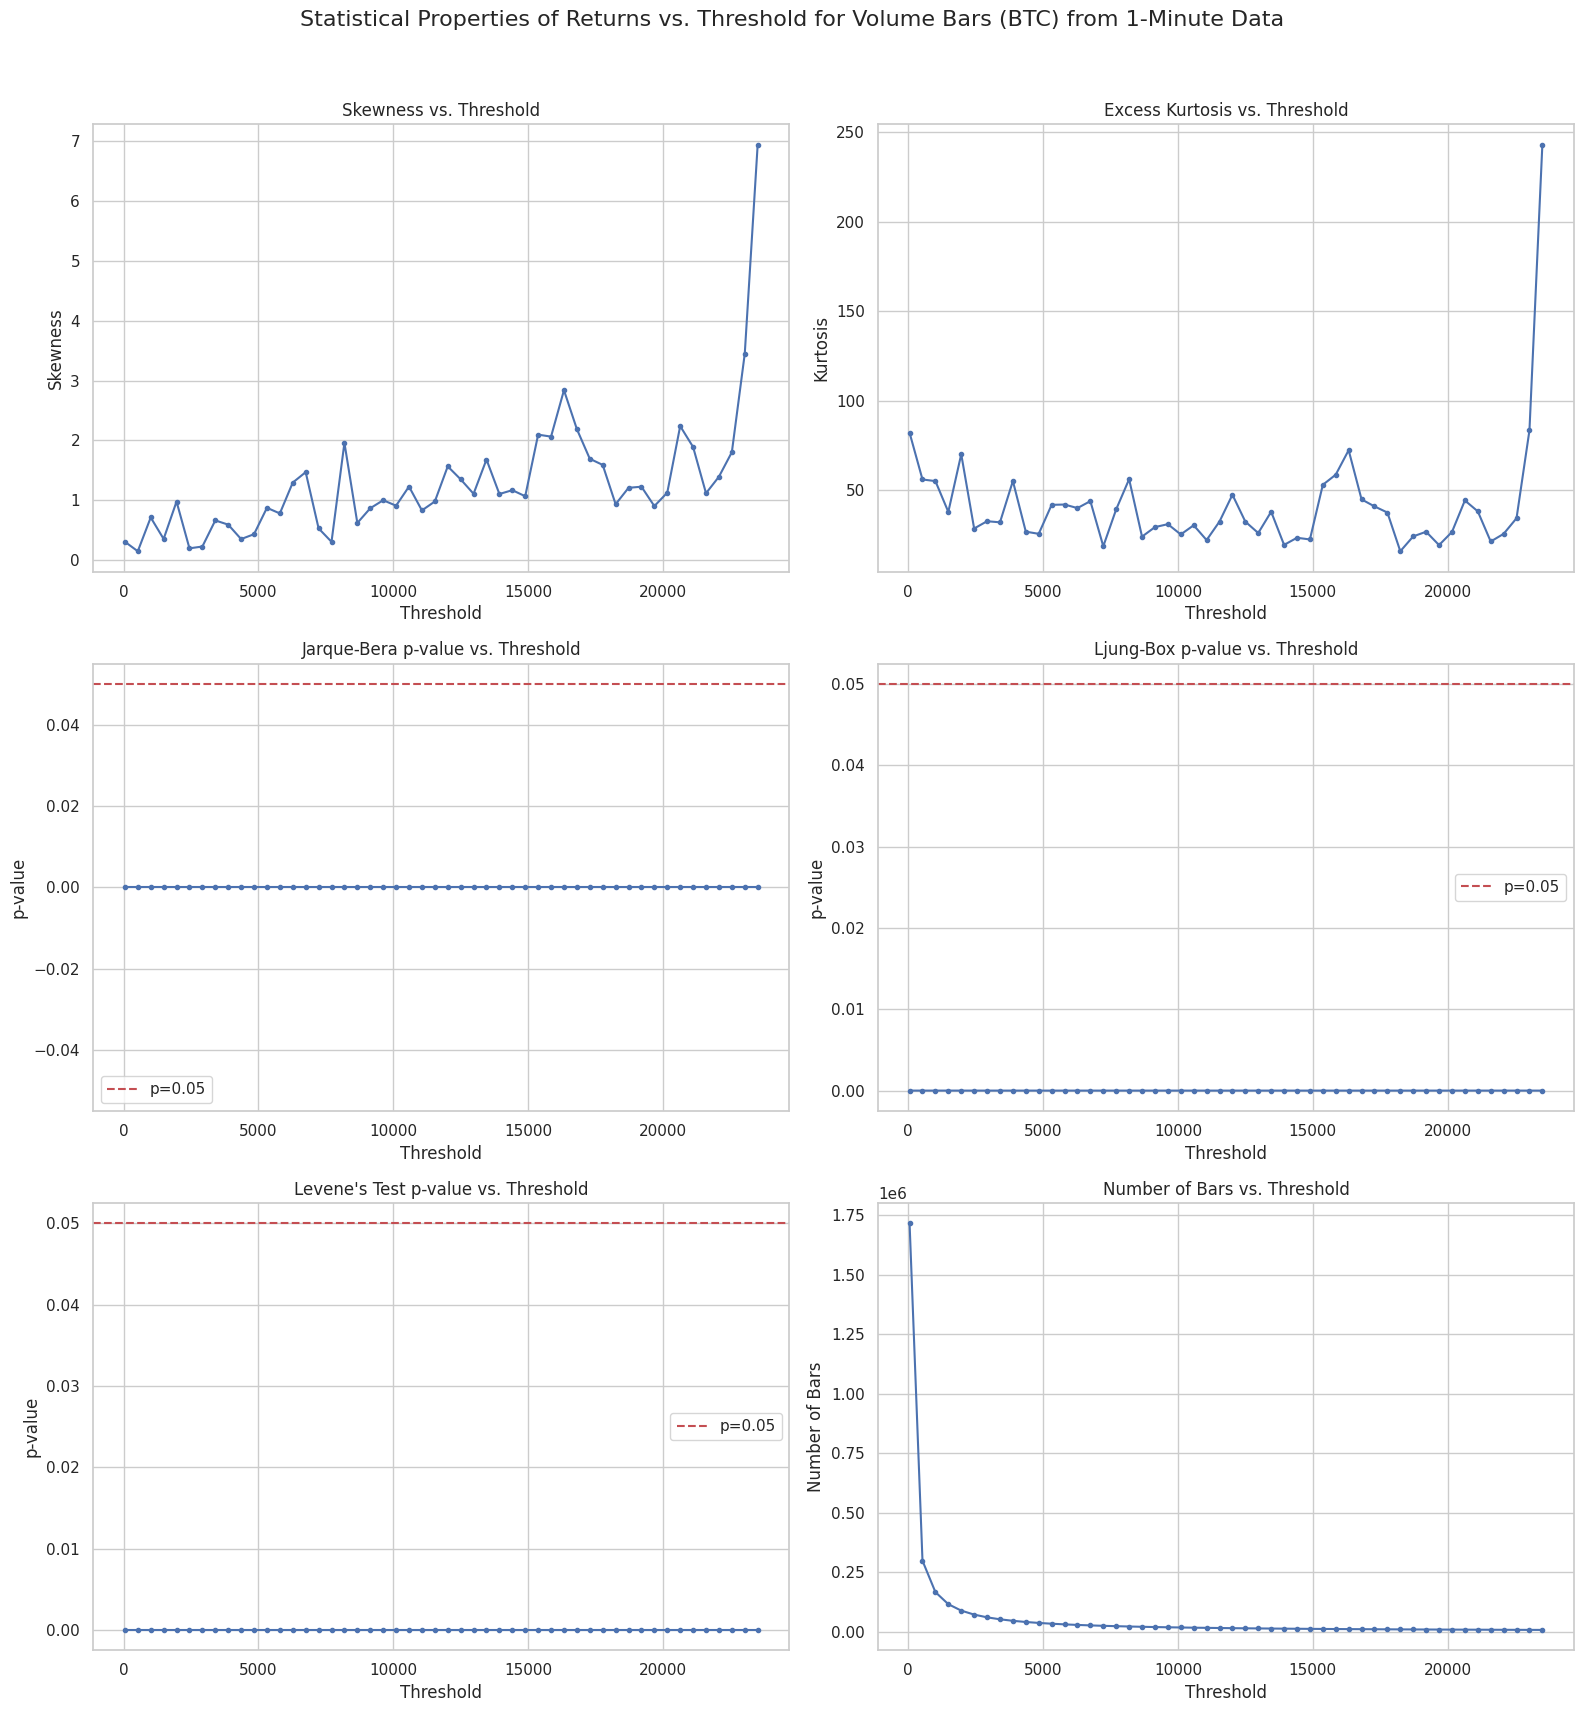

In [26]:
plot_threshold_sweep_analysis(
    df_for_bars=df_for_bars_1m,
    bar_creation_func=create_volume_bars,
    metric_series=df_1m['Volume BTC'],
    sweep_title="Volume Bars (BTC) from 1-Minute Data"
)

### 10.2. Dollar Bar Threshold Sweep (1-Minute Data)


--- Starting Threshold Sweep Analysis for Dollar Bars (USDT) from 1-Minute Data ---
Plotting results for Dollar Bars (USDT) from 1-Minute Data...


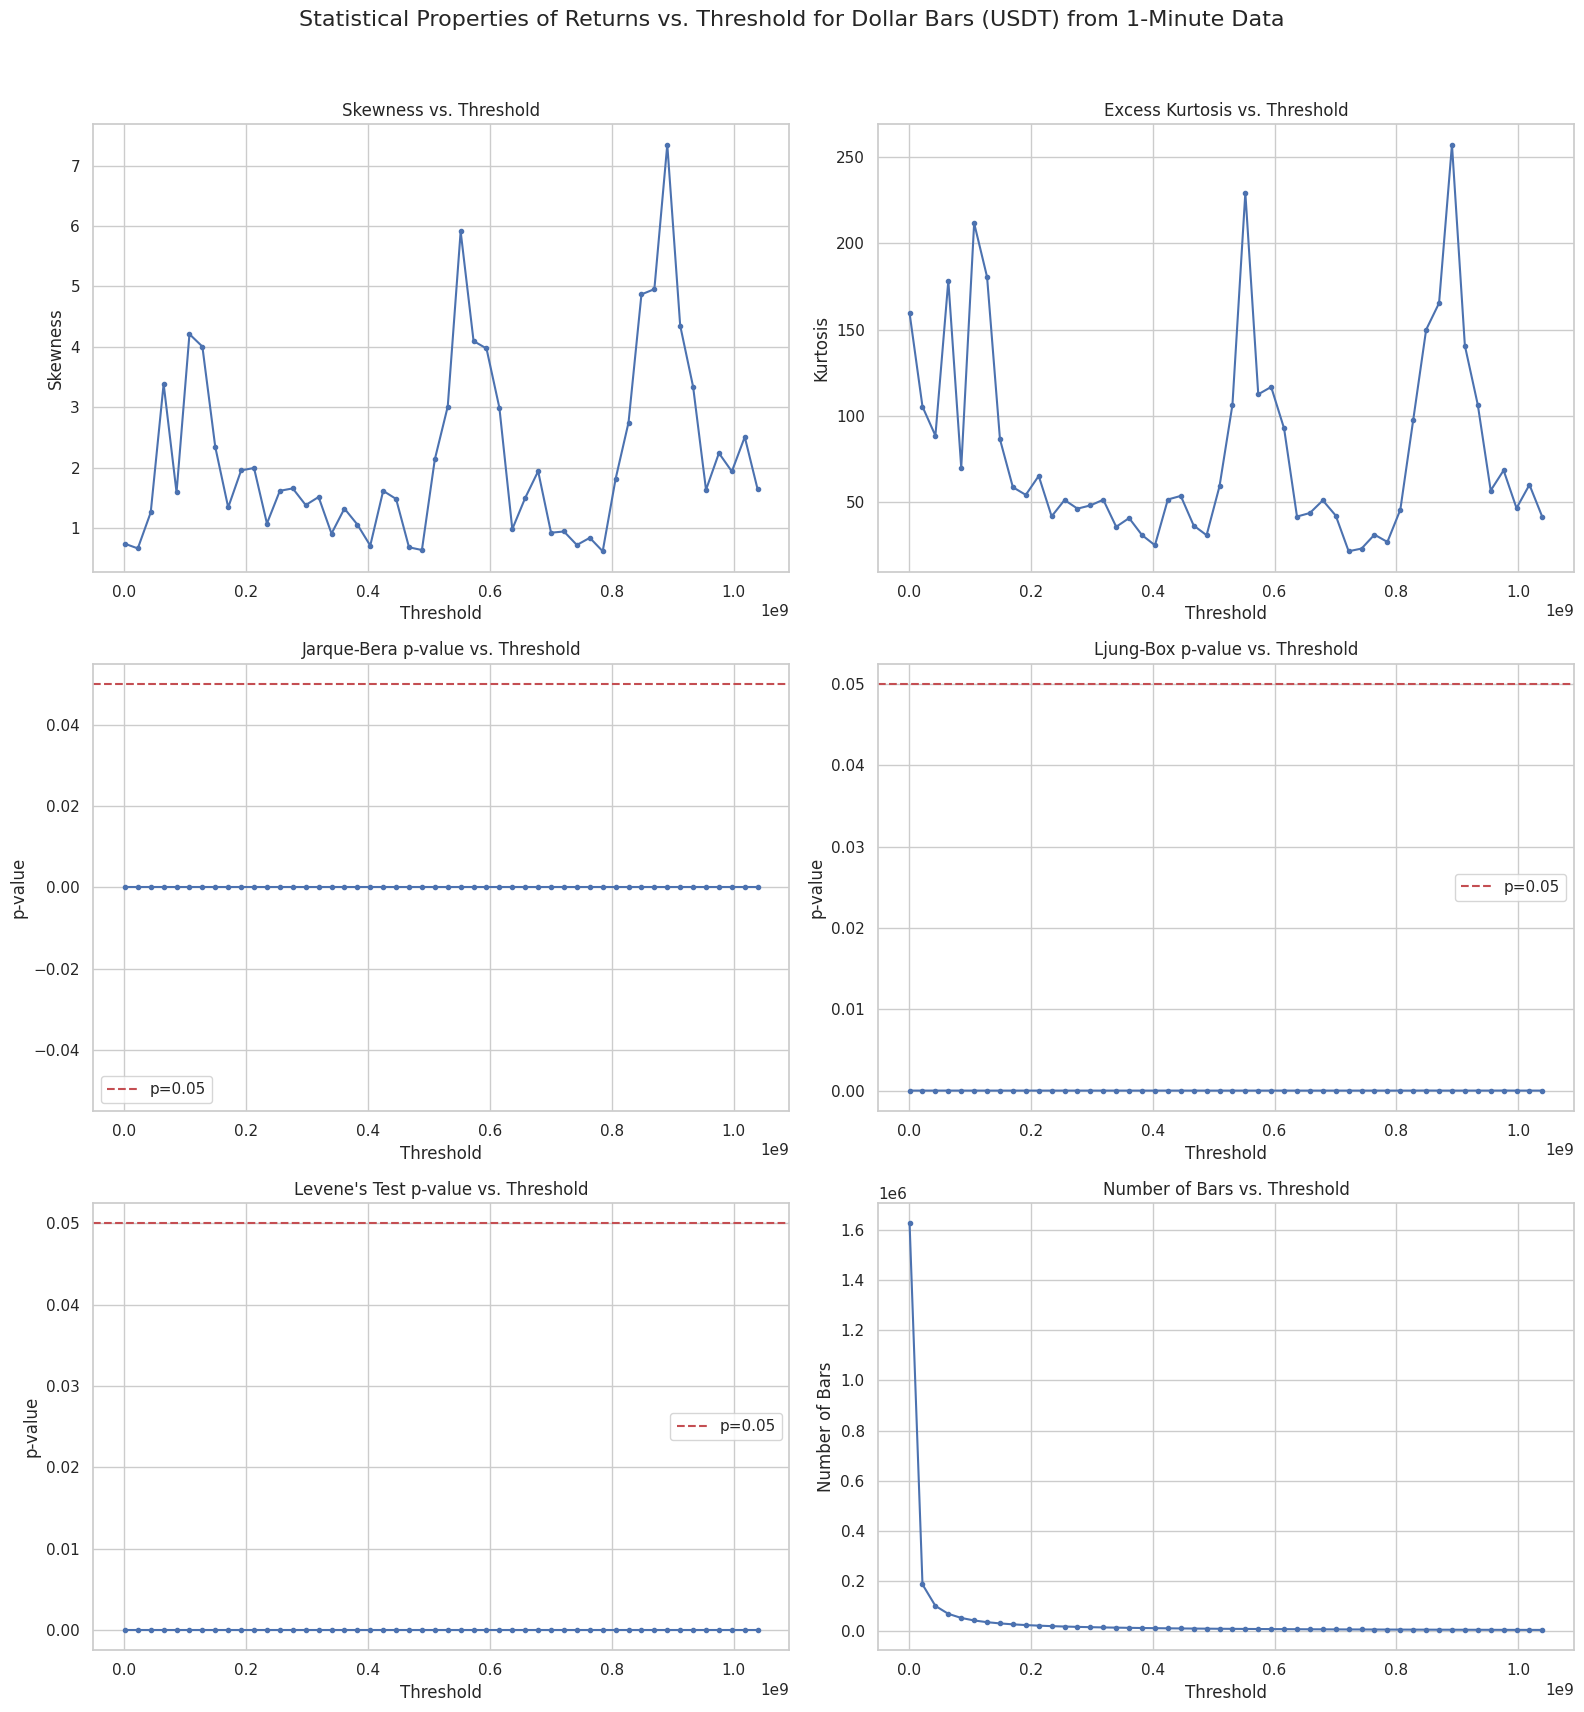

In [27]:
plot_threshold_sweep_analysis(
    df_for_bars=df_for_bars_1m,
    bar_creation_func=create_dollar_bars,
    metric_series=df_1m['Volume USDT'],
    sweep_title="Dollar Bars (USDT) from 1-Minute Data"
)

### 10.3. Price Change Bar Threshold Sweep (1-Minute Data)


--- Starting Threshold Sweep Analysis for Price Change Bars from 1-Minute Data ---
Plotting results for Price Change Bars from 1-Minute Data...


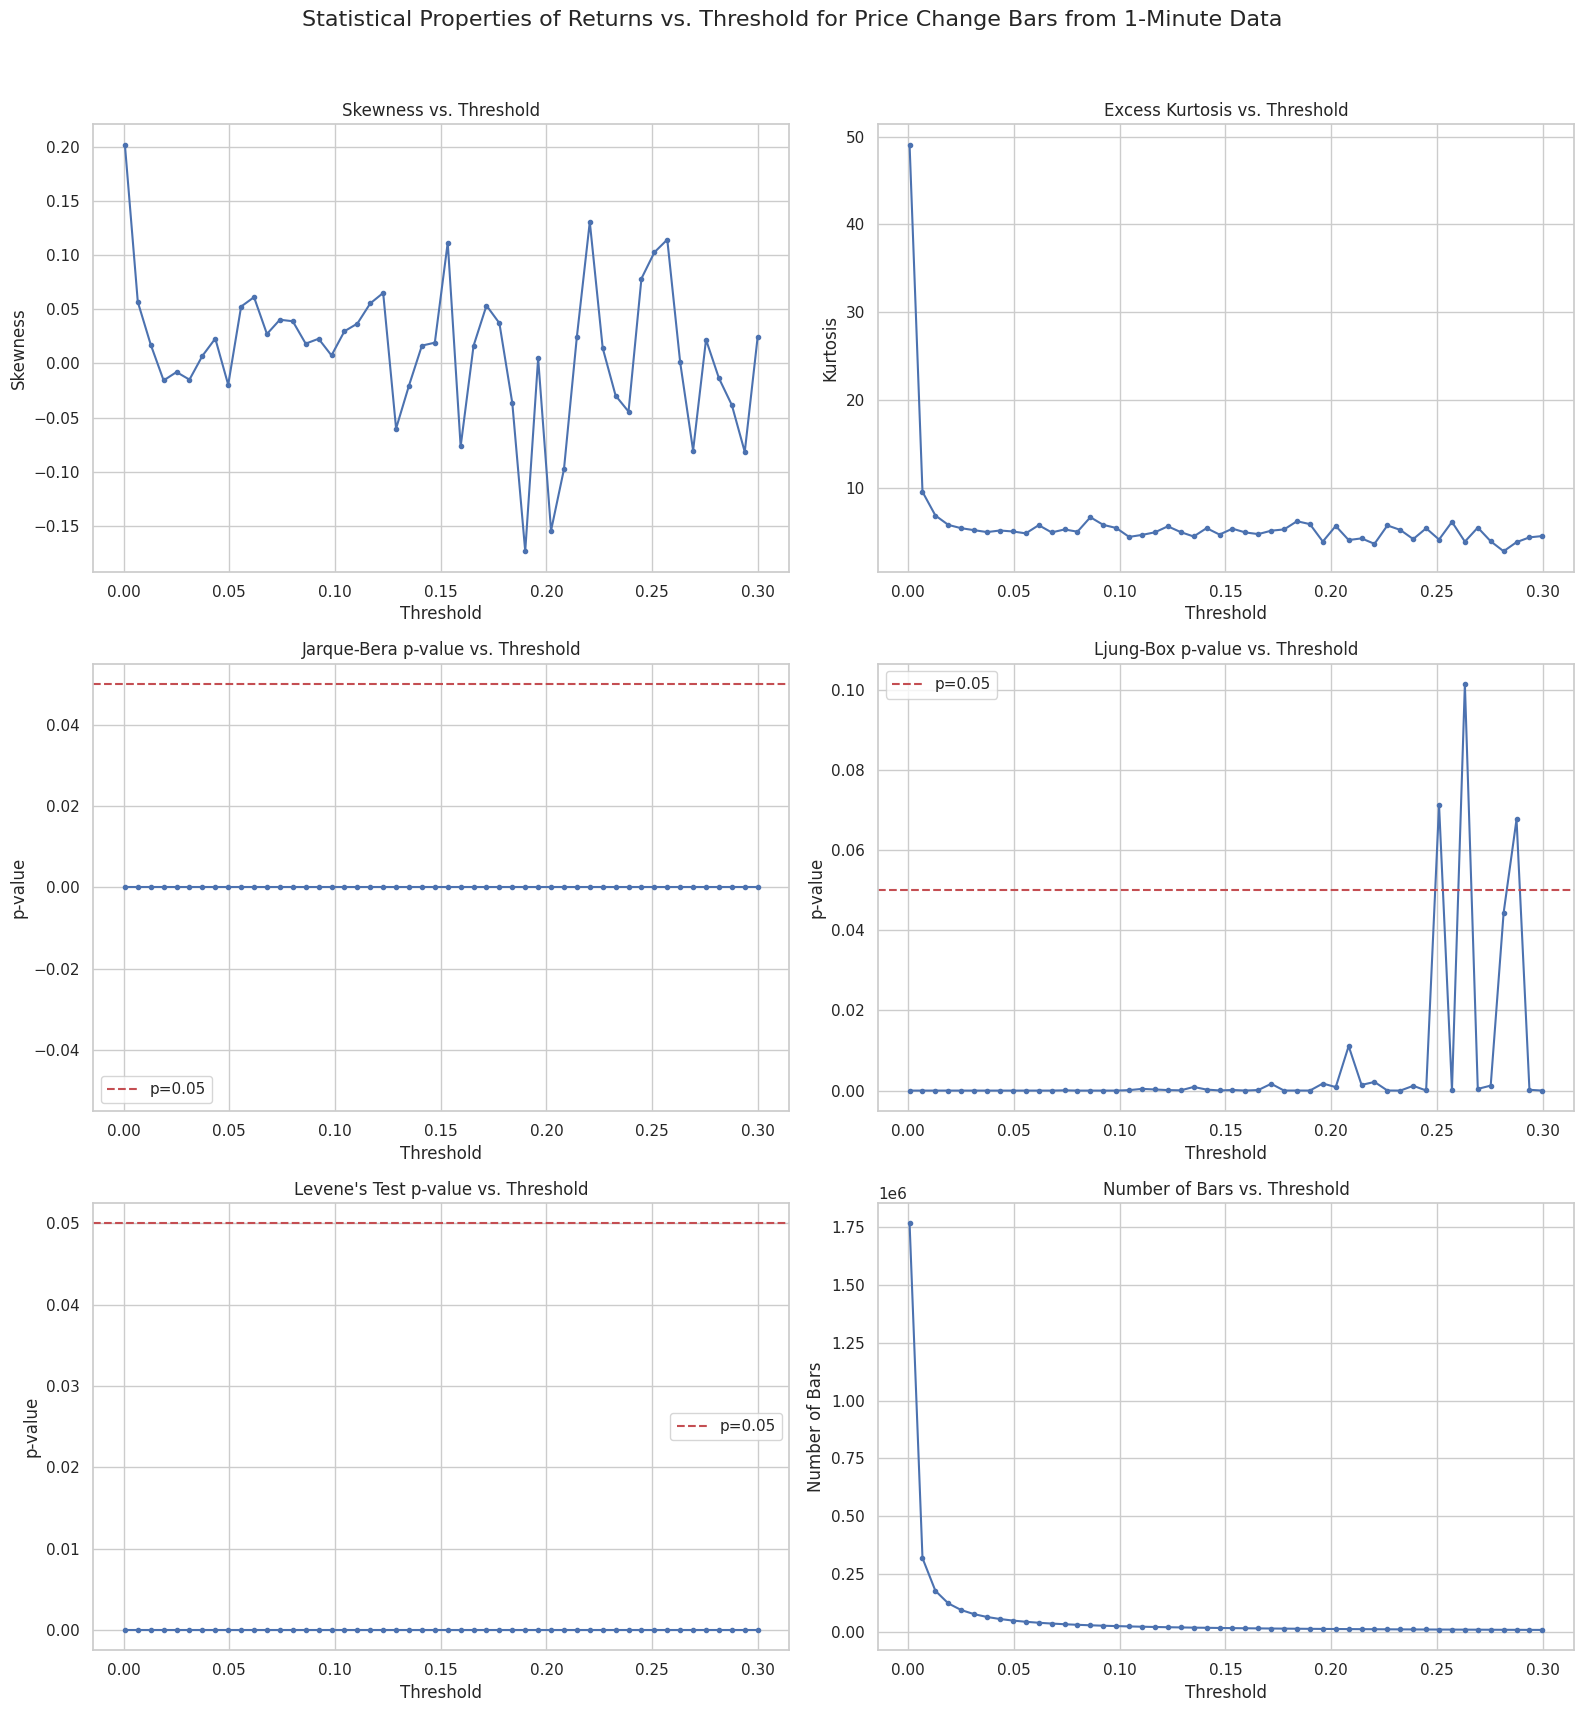

In [28]:
# Calculate absolute fractional price change to use for the metric series
abs_frac_change_1m = df_1m['close'].pct_change().abs().dropna()

plot_threshold_sweep_analysis(
    df_for_bars=df_for_bars_1m,
    bar_creation_func=create_price_change_bars,
    metric_series=abs_frac_change_1m,
    sweep_title="Price Change Bars from 1-Minute Data"
)

### 10.4. Summary of 1-Minute Data Analysis

The analysis on 1-minute data generally confirms the findings from the hourly data: using activity-based bars tends to improve the statistical properties of the returns series. However, the scale of the thresholds is much smaller due to the finer time resolution. The trends of decreasing kurtosis and serial correlation with increasing thresholds remain consistent, reinforcing the validity of this sampling technique across different timeframes.